# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version - these are counterbalanced across the 2 conditions (feedback/no feedback) and image/word assignment (which images form the congruent vs. incongruent context).

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run. The first 3 are the main task images at PC 75:25, the last run is the transfer phase/image pairing (PC-50/50).

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the image is a mostly incongruent (1) or mostly congruent (0) context.

`ImagePresented` refers to the image on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each image have only one incongruent and congruent stimulus. So, there are only 8 pairings.

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3). In the No Feedback condition, the participants only got the feedback time-out.

`runStart` refers to the initiation of the countdown to begin the block; `StimTime` refers to when the image was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`StimRep` looks for direct stimulus repetitions (StroopNum).

---

### Here we'll just import Python specific packages and read in our data.

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [345]:
%cd C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispc\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\ispc\\data\\csvdata\\'

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispc\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [346]:
cdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier and understandable by other folks.

In [347]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    df['Feedback'] = df['Version'].isin([7,8,9,10,11,12])
    df.loc[df['Version'].isin([7,8,9,10,11,12]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([1,2,3,4,5,6]), 'Feedback'] = 'NoFeedback'
    
    df['Transfer'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2,3]), 'Transfer'] = 'MainTask'
    df.loc[df['RunCounter'].isin([4]), 'Transfer'] = 'TransferTask'
    
    df['DemandCue'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'DemandCue'] = 'PC-25'
    df.loc[df['ContextType'].isin([0]), 'DemandCue'] = 'PC-75'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['ContextCong'] = df['DemandCue'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['DemandCue'].isin(['PC-25']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['DemandCue'].isin(['PC-75']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['DemandCue'].isin(['PC-25']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['DemandCue'].isin(['PC-75']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### In a typical item-specific proportion congruent paradigm, we would expect to find a congruency by proportion congruent interaction such that there is a reduced congruency difference for images that are in the "low" proportion congruent condition vs. "high" proportion congruent condition. The basic idea is that participants learn to adjust their attentional priorities for the context they are currently in, and they need to recruit more attentional focus in the low PC condition.

### Here we are looking to replicate a basic picture-word ISPC effect with our "No Feedback" group, and we are also investigating the effects of performance feedback on the ISPC effect. Because participants do not know in advance of the trial which image/context will appear, the ISPC is thought to reflect reactive control or control that is recruited in the moment. It has been hypothesized that proactive control is particularly sensitive to reward (like performance feedback), but perhaps that does not impact the ISPC/reactive control. No one has investigated how feedback can affect control-learning.

In [348]:
def mean_cueing_effect(df, dv, Filter1, Filter2, Context):
    if Context == 1:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','ContextCong'])[dv].mean()
    else:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','CSE'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(sub_means))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [349]:
mean_cueing_effect(cdat, 'RT', 'NoFeedback', 'MainTask',1)

(ContextCong
 HighC     652.304565
 HighIC    660.724298
 LowC      658.414658
 LowIC     672.518533
 Name: RT, dtype: float64, ContextCong
 HighC     5.282961
 HighIC    5.393084
 LowC      6.419817
 LowIC     6.457948
 Name: RT, dtype: float64)

In [350]:
mean_cueing_effect(cdat, 'RT', 'Feedback', 'MainTask',1)

(ContextCong
 HighC     640.196887
 HighIC    656.606612
 LowC      647.700456
 LowIC     658.694217
 Name: RT, dtype: float64, ContextCong
 HighC     4.411210
 HighIC    4.737006
 LowC      4.337496
 LowIC     4.452076
 Name: RT, dtype: float64)

What about transfer?

In [351]:
mean_cueing_effect(cdat, 'RT', 'NoFeedback', 'TransferTask',1)

(ContextCong
 HighC     643.243241
 HighIC    645.904828
 LowC      649.353666
 LowIC     654.217827
 Name: RT, dtype: float64, ContextCong
 HighC     5.661100
 HighIC    5.372339
 LowC      6.551608
 LowIC     6.182289
 Name: RT, dtype: float64)

In [352]:
mean_cueing_effect(cdat, 'RT', 'Feedback', 'TransferTask',1)

(ContextCong
 HighC     643.295690
 HighIC    649.030770
 LowC      647.925617
 LowIC     648.278796
 Name: RT, dtype: float64, ContextCong
 HighC     4.370000
 HighIC    4.874523
 LowC      5.088962
 LowIC     4.673106
 Name: RT, dtype: float64)

#### Now, what of Accuracy?

In [353]:
mean_cueing_effect(adat, 'Accuracy', 'NoFeedback', 'MainTask',1)

(ContextCong
 HighC     0.915889
 HighIC    0.905220
 LowC      0.924794
 LowIC     0.897423
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.008474
 HighIC    0.008280
 LowC      0.004965
 LowIC     0.010016
 Name: Accuracy, dtype: float64)

In [354]:
mean_cueing_effect(adat, 'Accuracy', 'Feedback', 'MainTask',1)

(ContextCong
 HighC     0.898438
 HighIC    0.888393
 LowC      0.894921
 LowIC     0.852877
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.009011
 HighIC    0.008416
 LowC      0.007518
 LowIC     0.009200
 Name: Accuracy, dtype: float64)

Transfer for Accuracy...

In [355]:
mean_cueing_effect(adat, 'Accuracy', 'NoFeedback', 'TransferTask',1)

(ContextCong
 HighC     0.915283
 HighIC    0.927054
 LowC      0.930024
 LowIC     0.921598
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.006333
 HighIC    0.005864
 LowC      0.005601
 LowIC     0.005770
 Name: Accuracy, dtype: float64)

In [356]:
mean_cueing_effect(adat, 'Accuracy', 'Feedback', 'TransferTask',1)

(ContextCong
 HighC     0.893245
 HighIC    0.870942
 LowC      0.903007
 LowIC     0.882660
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.009420
 HighIC    0.011815
 LowC      0.008728
 LowIC     0.011525
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

In [357]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispc\data\csvdata


In [358]:
RTmeans = cdat.loc[cdat['Transfer']=='MainTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Transfer']=='MainTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans_T = cdat.loc[cdat['Transfer']=='TransferTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['RT'].mean().reset_index();
ACCmeans_T = adat.loc[adat['Transfer']=='TransferTask'].groupby(['subject', 'DemandCue','Congruency', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_T.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_T.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [359]:
%%writefile SCAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawRTData <- read.csv('SC_ANOVA_RT.csv')

rawRTData$subject = as.factor(rawRTData$subject)
rawRTData$DemandCue = as.factor(rawRTData$DemandCue)
rawRTData$Congruency = as.factor(rawRTData$Congruency)
rawRTData$Feedback = as.factor(rawRTData$Feedback)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')

rawRTData_T$subject = as.factor(rawRTData_T$subject)
rawRTData_T$DemandCue = as.factor(rawRTData_T$DemandCue)
rawRTData_T$Congruency = as.factor(rawRTData_T$Congruency)
rawRTData_T$Feedback = as.factor(rawRTData_T$Feedback)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawRTData_T),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')

rawACCData$subject = as.factor(rawACCData$subject)
rawACCData$DemandCue = as.factor(rawACCData$DemandCue)
rawACCData$Congruency = as.factor(rawACCData$Congruency)
rawACCData$Feedback = as.factor(rawACCData$Feedback)

SC_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_ACC_runANOVA)

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')

rawACCData_T$subject = as.factor(rawACCData_T$subject)
rawACCData_T$DemandCue = as.factor(rawACCData_T$DemandCue)
rawACCData_T$Congruency = as.factor(rawACCData_T$Congruency)
rawACCData_T$Feedback = as.factor(rawACCData_T$Feedback)

SCT_ACC_runANOVA <- ezANOVA(data=as.data.frame(rawACCData_T),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(DemandCue, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_ACC_runANOVA)

Overwriting SCAnova.R


In [360]:
! Rscript SCAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpK06u7s\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpK06u7s\downloaded_packages
$ANOVA
                         Effect DFn DFd          SSn        SSd            F
1                   (Intercept)   1  58 1.032476e+08 714497.025 8.381225e+03
2                      Feedback   1  58 6.231353e+03 714497.025 5.058362e-01
3                     DemandCue   1  58 2.835010e+03  36561.940 4.497316e+00
5                    Congruency   1  58 9.347680e+03  10187.624 5.321805e+01
4            Feedback:DemandCue   1  58 2.591569e+02  36561.940 4.111134e-01
6           Feedback:Congruency   1  58 8.929953e+01  10187.624 5.083985e-01
7          DemandCue:Congruency   1  58 2.696989e-01   5909.054 2.647215e-03
8 Feedback:DemandCue:Congruency   1  58 4.620463e+02

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


We don't seem to observe a transfer ISPC, but we do seem to find some evidence of an ISPC - however, acc & RT show different patterns (2-way vs. 3-way interaction significant). What does this look like graphically?

# Look at the Results Graphically

In [361]:
figurepath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\ispc\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [362]:
def mybargraph(x,y,hue,col,order,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       col=col,
                       order=order,
                       data=data,
                       palette="colorblind",
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = ["No Feedback Group", "Feedback Group"]
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


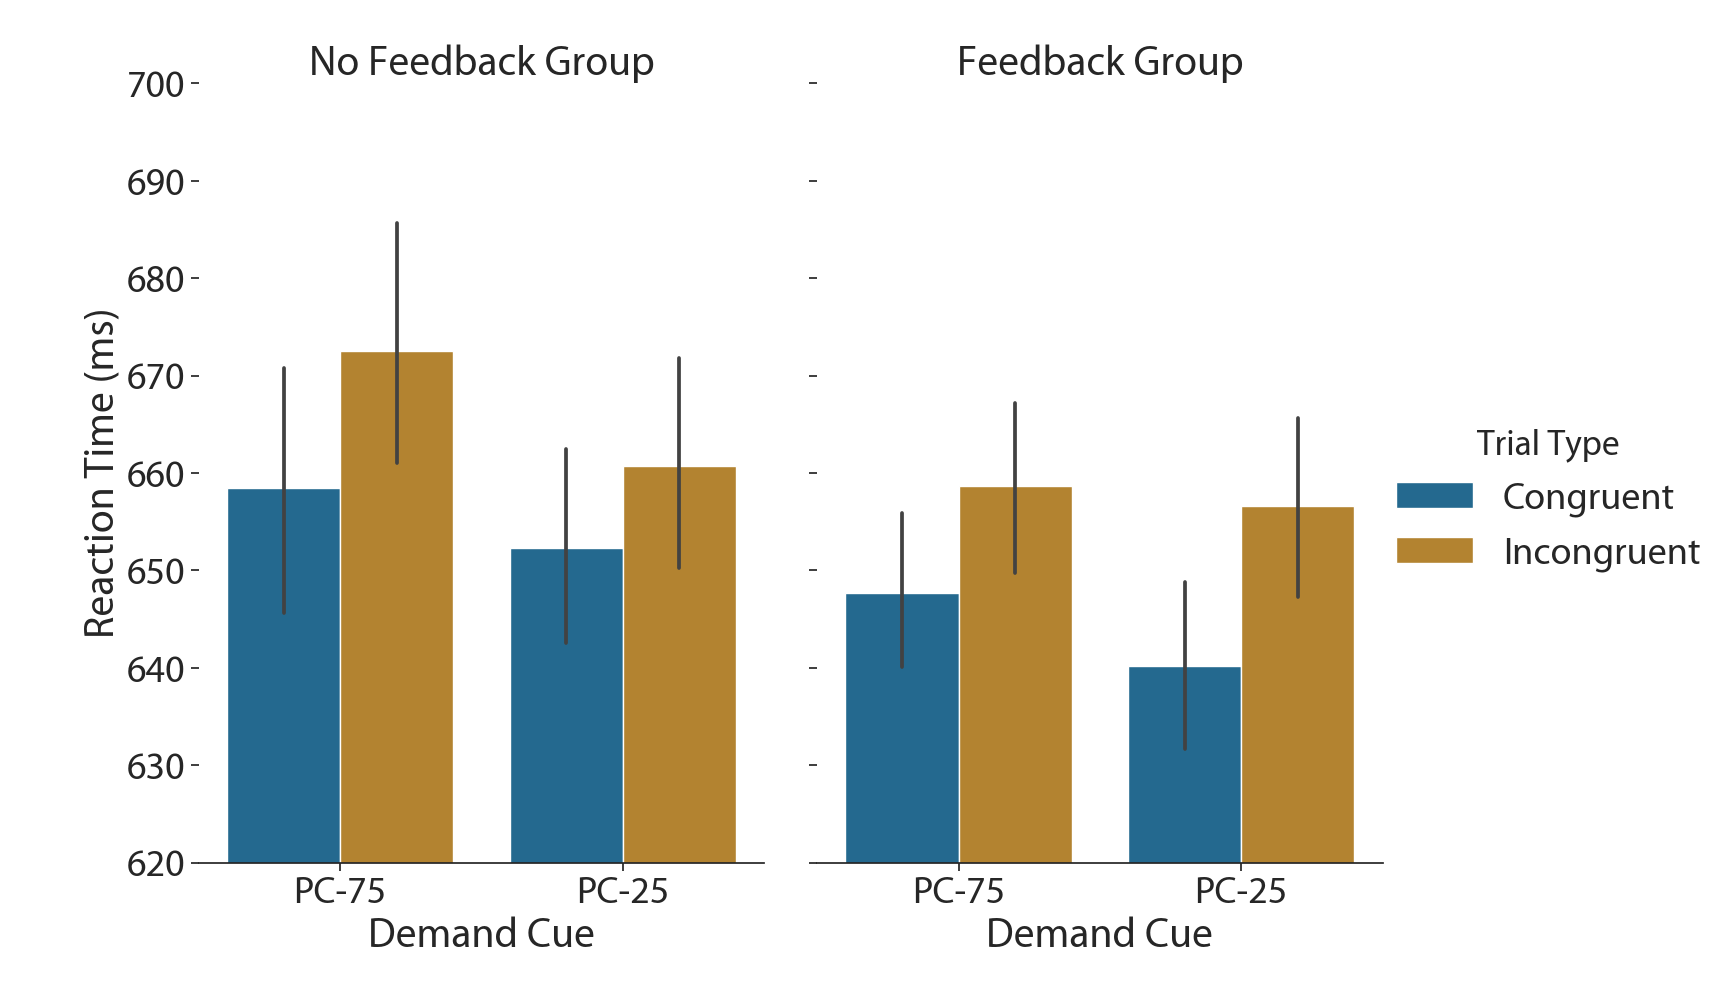

In [363]:
mybargraph("DemandCue","RT","Congruency","Feedback",["PC-75", "PC-25"],RTmeans,"Demand Cue","Reaction Time (ms)","Experiment 1a","Trial Type",620,700,"ISPC_RT_maintask.png",10)

<IPython.core.display.Javascript object>


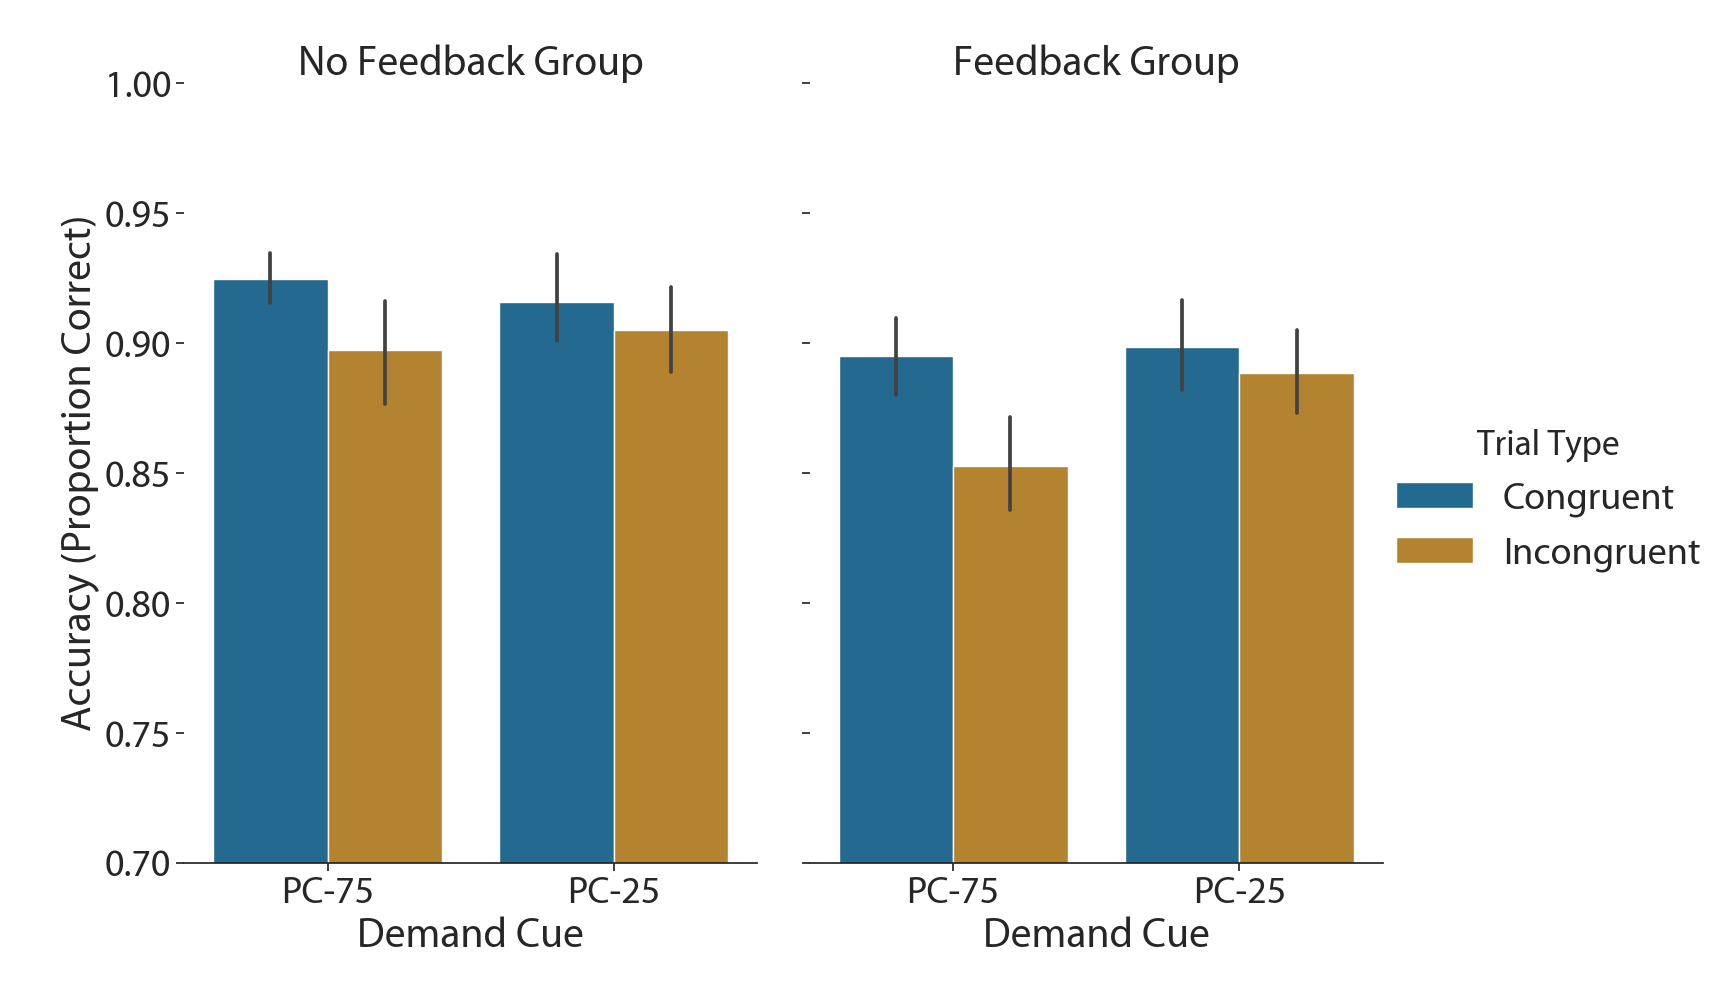

In [364]:
mybargraph("DemandCue","Accuracy","Congruency","Feedback",["PC-75", "PC-25"],ACCmeans,"Demand Cue","Accuracy (Proportion Correct)","Experiment 1a","Trial Type",0.7,1.0,"ISPC_ACC_maintask.png",0.05)

<IPython.core.display.Javascript object>


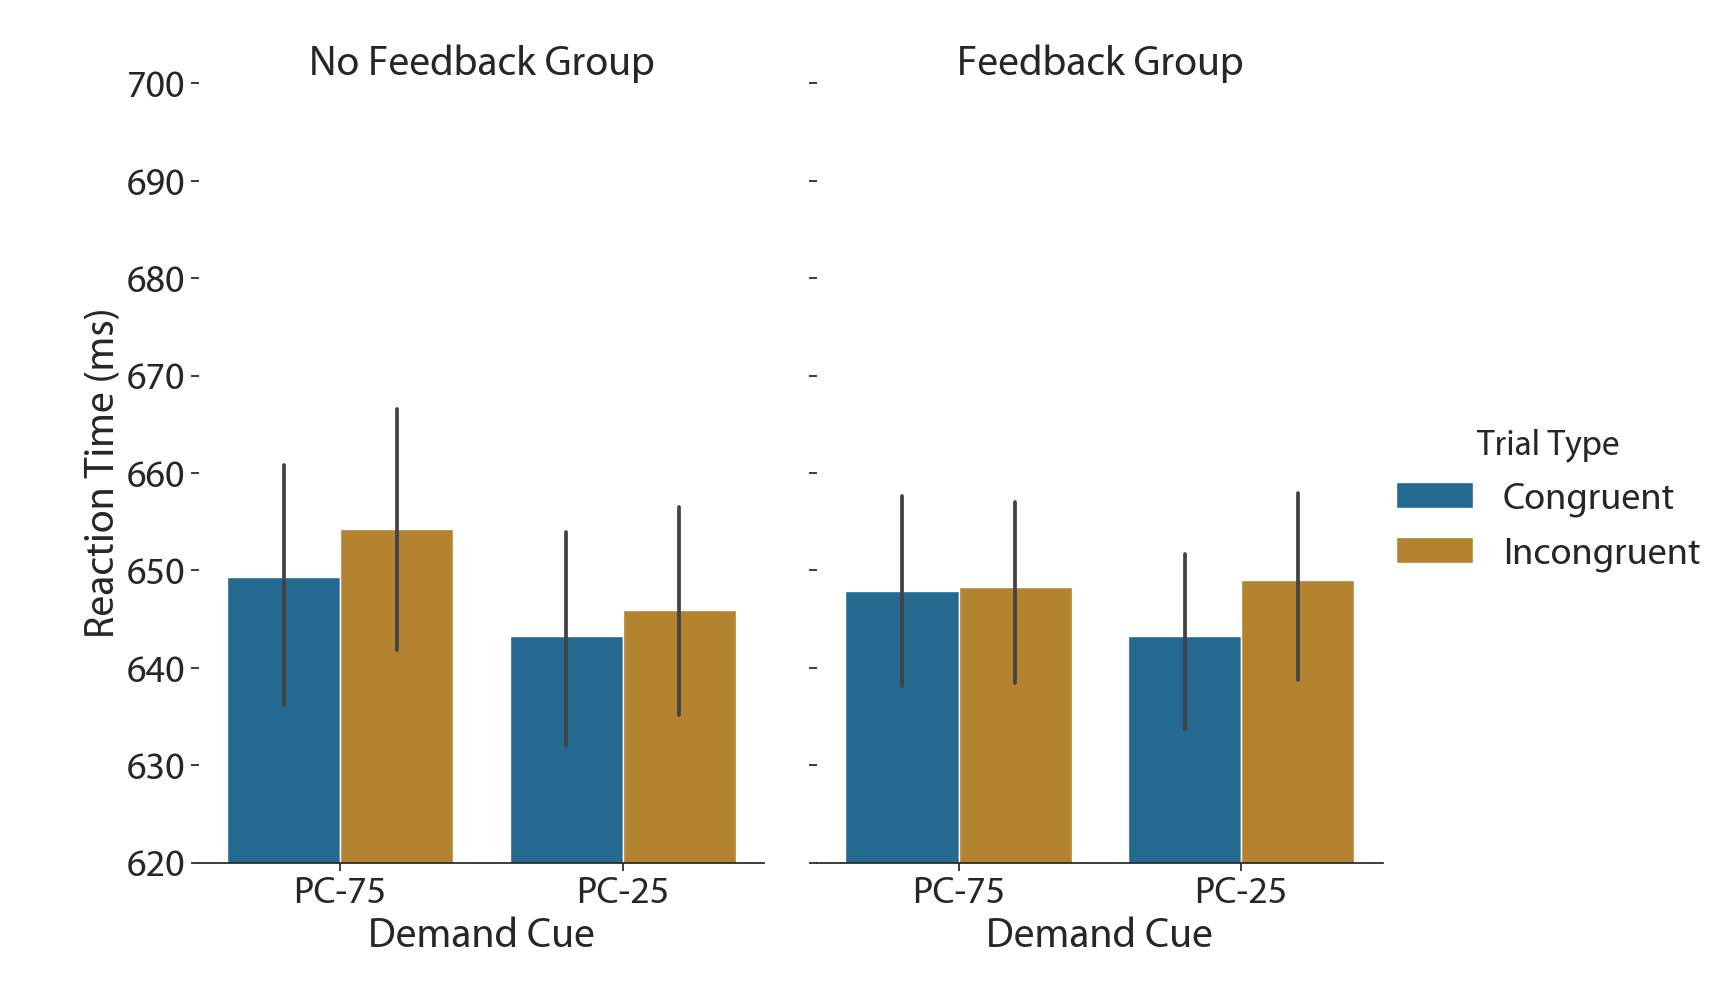

In [365]:
mybargraph("DemandCue","RT","Congruency","Feedback",["PC-75", "PC-25"],RTmeans_T,"Demand Cue","Reaction Time (ms)","Experiment 1a Transfer","Trial Type",620,700,"ISPC_RT_transfertask.png",10)

<IPython.core.display.Javascript object>


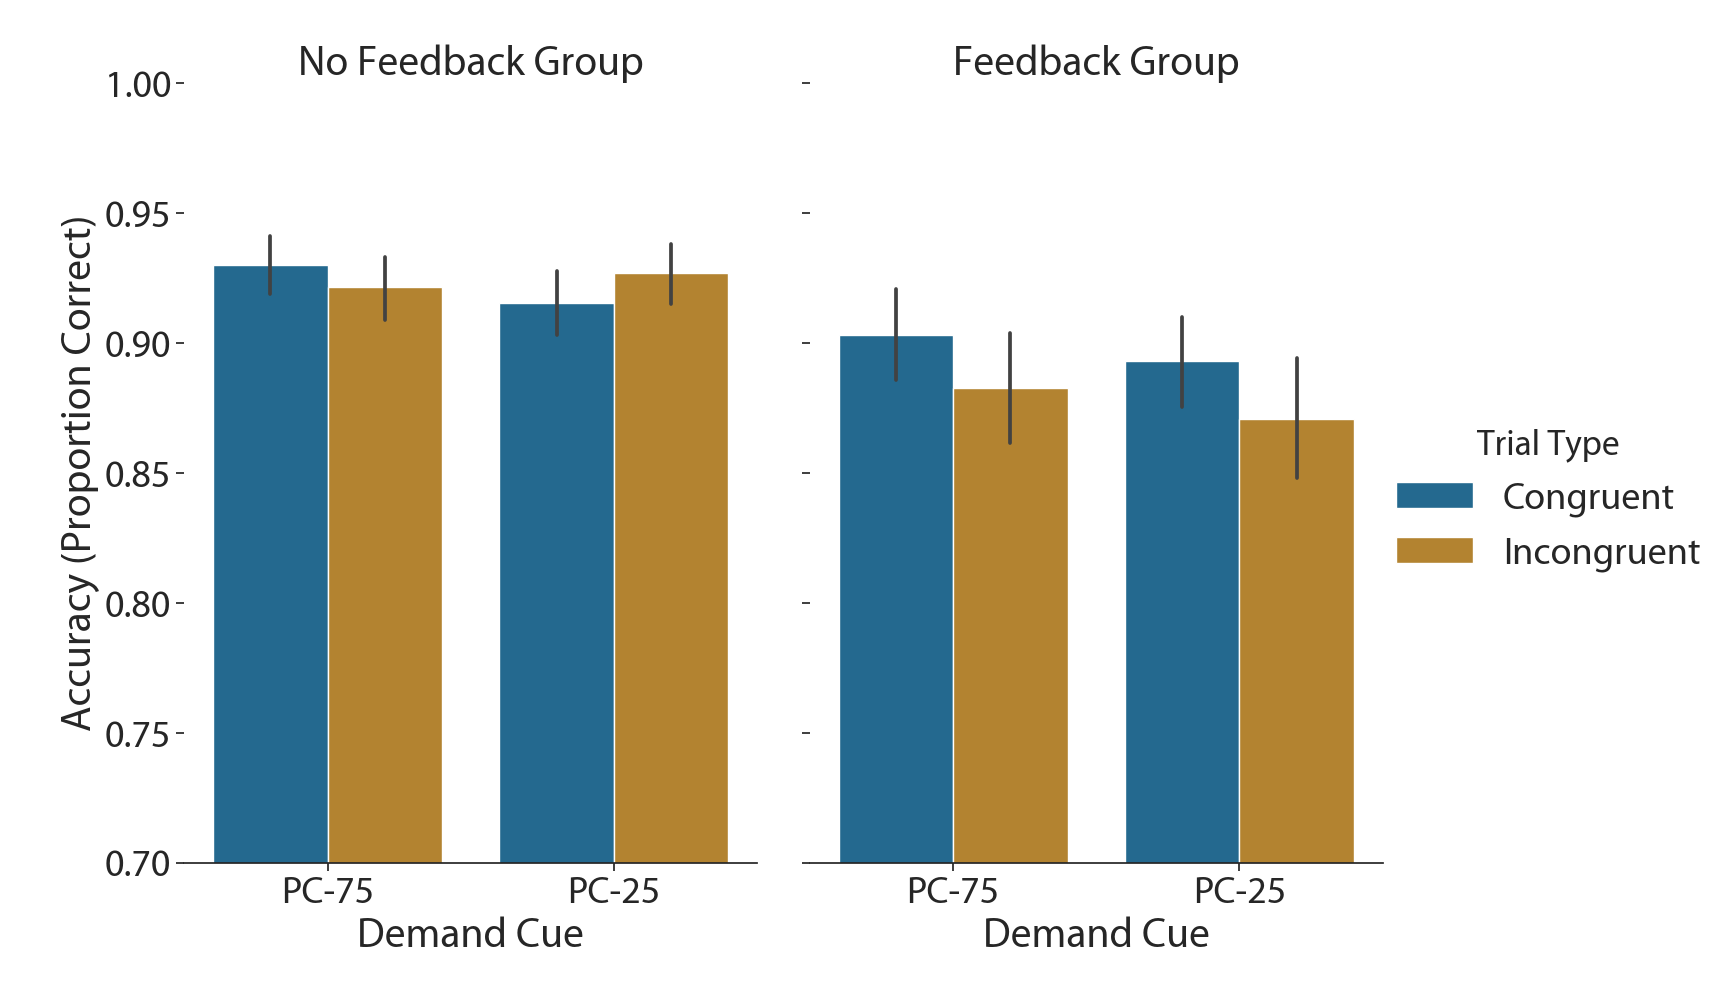

In [366]:
mybargraph("DemandCue","Accuracy","Congruency","Feedback",["PC-75", "PC-25"],ACCmeans_T,"Demand Cue","Accuracy (Proportion Correct)","Experiment 1a Transfer","Trial Type",0.7,1.0,"ISPC_ACC_transfertask.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction
##### also used to calculate inverse efficiency scores, test RT/acc trade-off

In [367]:
FBsubslim = 60;
NoFBsubslim = 30; #subs 1-30 in the list are no fb grp, while 31-60 are fb

In [368]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
NoFB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();
NoFB_ACC = pd.DataFrame();

In [369]:
def create_wide_df(df,dfname,dv,Group,lim1,lim2):
    lists = [[] for list in range(0,9)]
    data = df[df.Feedback == Group]
    
    for ID in range(lim1, lim2):
        sub = data[data.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Transfer == 'MainTask']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Transfer == 'TransferTask']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]

In [370]:
create_wide_df(cdat,FB_RT,'RT','Feedback',NoFBsubslim+1,FBsubslim+1);

In [371]:
create_wide_df(cdat,NoFB_RT,'RT','NoFeedback',1,NoFBsubslim+1);

In [372]:
create_wide_df(adat,FB_ACC,'Accuracy','Feedback',(NoFBsubslim+1),(FBsubslim+1));

In [373]:
create_wide_df(adat,NoFB_ACC,'Accuracy','NoFeedback',1,NoFBsubslim+1);

In [374]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [375]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [376]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [377]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [378]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

In [379]:
SC_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 0, 1)

In [380]:
SCT_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 1, 1)

In [381]:
SC_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 0, 0)

In [382]:
SCT_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 1, 0)

In [383]:
#interaction effects - both groups
SC_RT = SC_RT_NoFB.append(SC_RT_FB)
SC_ACC = SC_ACC_NoFB.append(SC_ACC_FB)
SCT_RT = SCT_RT_NoFB.append(SCT_RT_FB)
SCT_ACC = SCT_ACC_NoFB.append(SCT_ACC_FB)

In [384]:
def means_overall_group(df, filternum, filter1, filter2, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Transfer'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Transfer'] == filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()
    
    X = X.drop('subject',1)
    
    return X

In [385]:
overallRT = means_overall_group(cdat, 0, 0, 0, 'RT')

In [386]:
overallACC = means_overall_group(adat, 0, 0, 0, 'Accuracy')

In [387]:
overallMainRT = means_overall_group(cdat, 1, 'MainTask', 0, 'RT')

In [388]:
overallMainACC = means_overall_group(adat, 1, 'MainTask', 0, 'Accuracy')

In [389]:
overallRT_T = means_overall_group(cdat, 1, 'TransferTask', 0, 'RT')

In [390]:
overallACC_T = means_overall_group(adat,  1, 'TransferTask', 0, 'Accuracy')

In [391]:
MainRT_FB = means_overall_group(cdat, 2, 'MainTask', 'Feedback', 'RT')

In [392]:
MainACC_FB = means_overall_group(adat, 2, 'MainTask', 'Feedback', 'Accuracy')

In [393]:
RT_FB_T = means_overall_group(cdat, 2, 'TransferTask', 'Feedback', 'RT')

In [394]:
ACC_FB_T = means_overall_group(adat, 2, 'TransferTask', 'Feedback', 'Accuracy')

In [395]:
MainRT_NoFB = means_overall_group(cdat, 2, 'MainTask', 'NoFeedback', 'RT')

In [396]:
MainACC_NoFB = means_overall_group(adat, 2, 'MainTask', 'NoFeedback', 'Accuracy')

In [397]:
RT_NoFB_T = means_overall_group(cdat, 2, 'TransferTask', 'NoFeedback', 'RT')

In [398]:
ACC_NoFB_T = means_overall_group(adat, 2, 'TransferTask', 'NoFeedback', 'Accuracy')

Now are there RT/ACC trade-offs?

In [399]:
#main task
stats.linregress(overallRT.RT,overallACC.Accuracy)

LinregressResult(slope=-0.0006873198858713298, intercept=1.3506835324274515, rvalue=-0.5066843542474083, pvalue=3.613621764424172e-05, stderr=0.00015356102506260399)

In [400]:
#transfer task
stats.linregress(overallRT_T.RT,overallACC_T.Accuracy)

LinregressResult(slope=-0.0006198097752171095, intercept=1.3066342216155504, rvalue=-0.4169310773857328, pvalue=0.0009200428641774752, stderr=0.0001774248581230729)

In [401]:
#main task w/in no FB group
stats.linregress(MainRT_NoFB.RT,MainACC_NoFB.Accuracy)

LinregressResult(slope=-0.0006888102833141542, intercept=1.3676597418699823, rvalue=-0.6031265071300033, pvalue=0.00041898918864792485, stderr=0.00017215598865214288)

In [402]:
#transfer task w/in no FB group
stats.linregress(RT_NoFB_T.RT,ACC_NoFB_T.Accuracy)

LinregressResult(slope=-0.00039163878916214945, intercept=1.1771453822006697, rvalue=-0.48383855696786543, pvalue=0.006749269033357333, stderr=0.0001338727902101297)

In [403]:
#main task w/in FB group
stats.linregress(MainRT_FB.RT,MainACC_FB.Accuracy)

LinregressResult(slope=-0.0009347971974980615, intercept=1.4964746612270998, rvalue=-0.5162789565446911, pvalue=0.003493275754653591, stderr=0.00029304951489277743)

In [404]:
#transfer task w/in FB group
stats.linregress(RT_FB_T.RT,ACC_FB_T.Accuracy)

LinregressResult(slope=-0.0009861149405335568, intercept=1.5252725503335636, rvalue=-0.47138395757580753, pvalue=0.008551248002563771, stderr=0.0003486638349618631)

# What about Inverse Efficiency, given the RT/ACC trade-off?

Inverse Efficiency is another metric that shows whether someone is more efficient at responding, not just faster (i.e., it doesn't come with a cost in accuracy). To calculate inverse efficiency, we take the mean RT in each condition and divide it by the mean Accuracy (Proportion Correct) in each condition, for each subject. This gives us an RT corrected for accuracy.

In [405]:
IE_FB = pd.DataFrame()
IE_NoFB = pd.DataFrame()
IE_all = pd.DataFrame()

IE_FB_T = pd.DataFrame()
IE_NoFB_T = pd.DataFrame()
IE_all_T = pd.DataFrame()

In [406]:
def inverse_efficiency_calc(df1, df2, Group, Transfer, dfname):
    #rt is df1 and proportion correct has to be df2
    lists = [[] for list in range(0,8)]
    
    for ID in range(0,len(df1)):
        sub = df1.SubjectID[ID]
        lists[0].append(sub)
        IE_LowC = df1.LowC[ID] / df2.LowC[ID]
        IE_LowIC = df1.LowIC[ID] / df2.LowIC[ID]
        IE_HighC = df1.HighC[ID] / df2.HighC[ID]
        IE_HighIC = df1.HighIC[ID] / df2.HighIC[ID]
        IE_LowC_T = df1.LowC_T[ID] / df2.LowC_T[ID]
        IE_LowIC_T = df1.LowIC_T[ID] / df2.LowIC_T[ID]
        IE_HighC_T = df1.HighC_T[ID] / df2.HighC_T[ID]
        IE_HighIC_T = df1.HighIC_T[ID] / df2.HighIC_T[ID]
        ISPC_Main = (IE_LowIC - IE_LowC) - (IE_HighIC - IE_HighC)
        ISPC_T = (IE_LowIC_T - IE_LowC_T) - (IE_HighIC_T - IE_HighC_T)
        avgIEtotal = (IE_LowC + IE_LowIC + IE_HighC + IE_HighIC) / 4
        avgIEtotal_T = (IE_LowC_T + IE_LowIC_T + IE_HighC_T + IE_HighIC_T) / 4
        
        if Transfer == 0:
            lists[1].append(IE_LowC)
            lists[2].append(IE_LowIC)
            lists[3].append(IE_HighC)
            lists[4].append(IE_HighIC)
            lists[5].append(ISPC_Main)
            lists[6].append(avgIEtotal)
        elif Transfer == 1:
            lists[1].append(IE_LowC_T)
            lists[2].append(IE_LowIC_T)
            lists[3].append(IE_HighC_T)
            lists[4].append(IE_HighIC_T)
            lists[5].append(ISPC_T)
            lists[6].append(avgIEtotal_T)
        
        lists[7].append(Group)
    
    dfname['SubjectID'] = lists[0]
    dfname['C1_1'] = lists[1]
    dfname['C1_2'] = lists[2]
    dfname['C2_1'] = lists[3]
    dfname['C2_2'] = lists[4]
    dfname['Effect'] = lists[5]
    dfname['OverallIE'] = lists[6]
    dfname['Feedback'] = lists[7]

In [407]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 0, IE_FB)

In [408]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 0, IE_NoFB)

In [409]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 1, IE_FB_T)

In [410]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 1, IE_NoFB_T)

In [411]:
IE_all = IE_NoFB.append(IE_FB)
IE_all_T = IE_NoFB_T.append(IE_FB_T)

In [412]:
def change_to_longform(df):
    X = pd.wide_to_long(df,['C1', 'C2'],i=["SubjectID", "Effect", "OverallIE", "Feedback"],j="Congruency",sep='_',suffix='\w')
    X = X.reset_index()
    X = pd.wide_to_long(X,['C'],i=["SubjectID","Effect", "OverallIE", "Feedback", "Congruency"],j="DemandCue")
    X = X.reset_index()
    X.columns = ['SubjectID', "Effect", "OverallIE", 'Feedback', 'Congruency', 'DemandCue', 'IE'];
    return X

In [413]:
IE_all = change_to_longform(IE_all)

In [414]:
IE_all_T = change_to_longform(IE_all_T)

In [415]:
#wide_to_long wasn't working if there were strings involved, so I used numbers for the levels and I'm renaming here
dflist = [IE_all, IE_all_T]

for df in dflist:
    df['TrialType'] = df['Congruency'].isin([1,2])
    df.loc[df['Congruency'].isin([1]),'TrialType'] = 'Congruent'
    df.loc[df['Congruency'].isin([2]),'TrialType'] = 'Incongruent'
    
    df['CueType'] = df['DemandCue'].isin([1,2])
    df.loc[df['DemandCue'].isin([1]),'CueType'] = 'PC-75'
    df.loc[df['DemandCue'].isin([2]),'CueType'] = 'PC-25'

In [416]:
avgIEmain = pd.DataFrame()

for ID in range(1,61):
    avgIE = IE_all.loc[IE_all.SubjectID == ID]
    tmpIE = avgIE.groupby(['SubjectID', "OverallIE", "Feedback"])['Effect'].mean().reset_index()
    avgIEmain = avgIEmain.append(tmpIE)

In [417]:
avgIE_T = pd.DataFrame()

for ID in range(1,61):
    avgIET = IE_all_T.loc[IE_all_T.SubjectID == ID]
    tmpIET = avgIET.groupby(['SubjectID', "OverallIE", "Feedback"])['Effect'].mean().reset_index()
    avgIE_T = avgIE_T.append(tmpIET)

In [418]:
IE_all.to_csv(csvpath+'IE_Main.csv');
IE_all_T.to_csv(csvpath+'IE_transfer.csv');

<IPython.core.display.Javascript object>


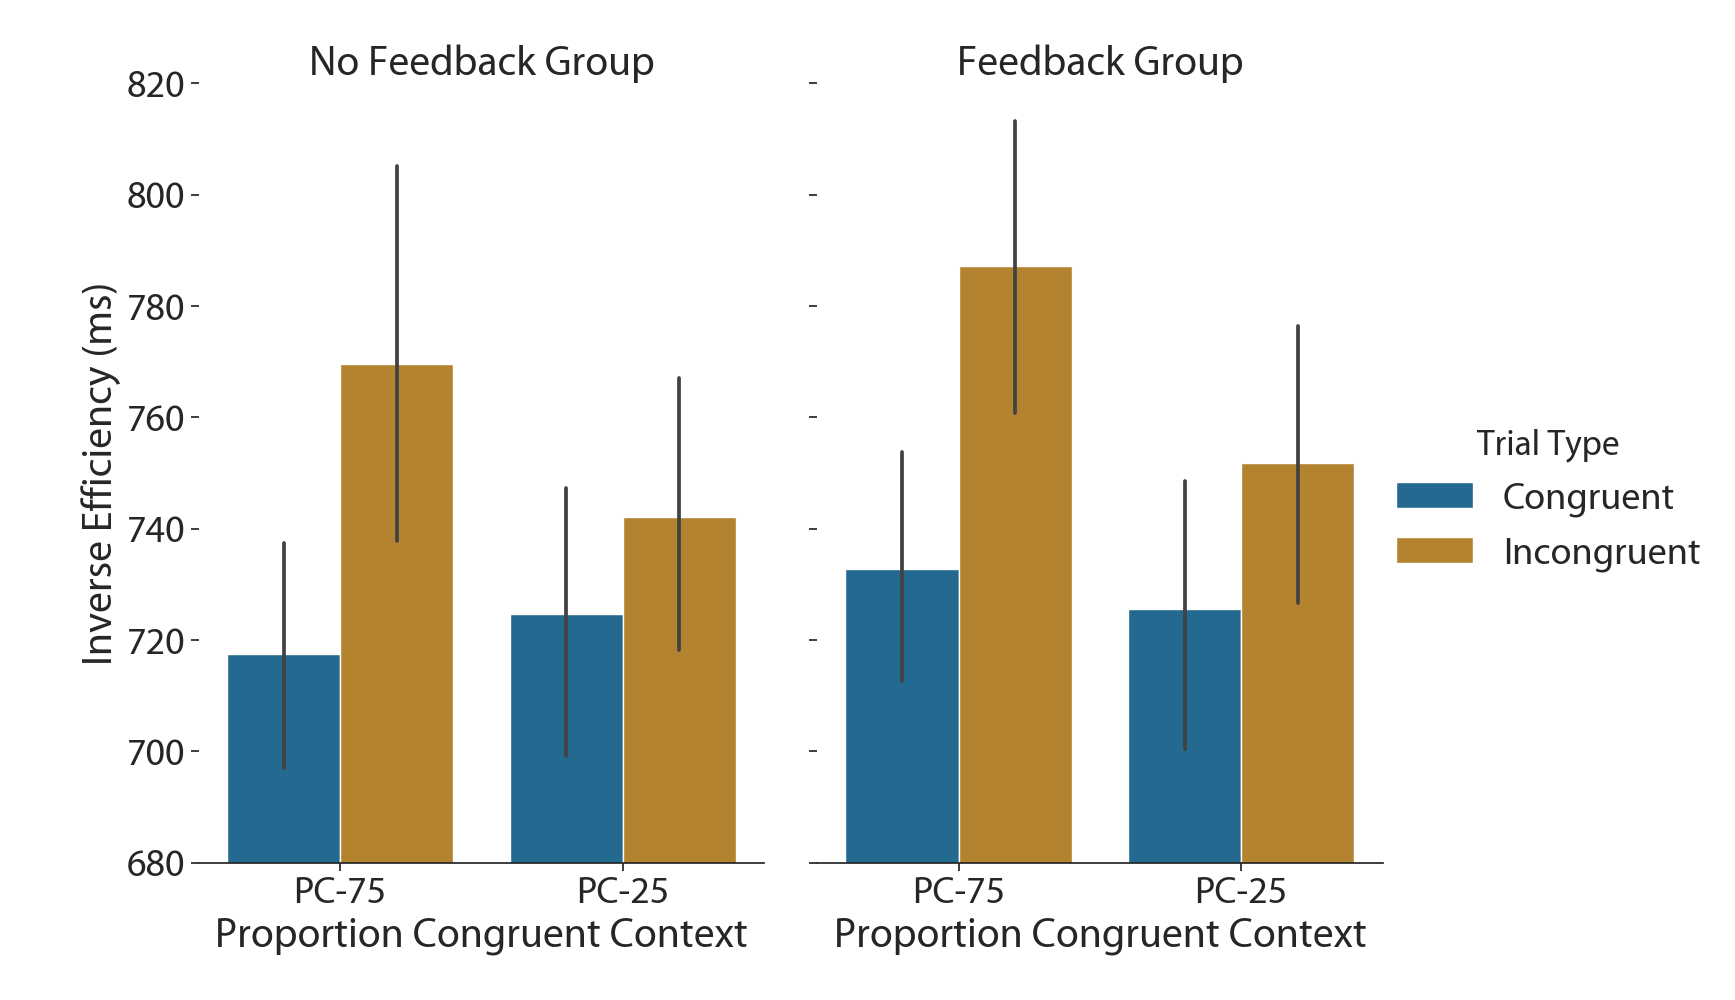

In [419]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-75", "PC-25"],IE_all,"Proportion Congruent Context","Inverse Efficiency (ms)","Experiment 1a","Trial Type",680,820,"ISPC_IE_maintask.png",20)

<IPython.core.display.Javascript object>


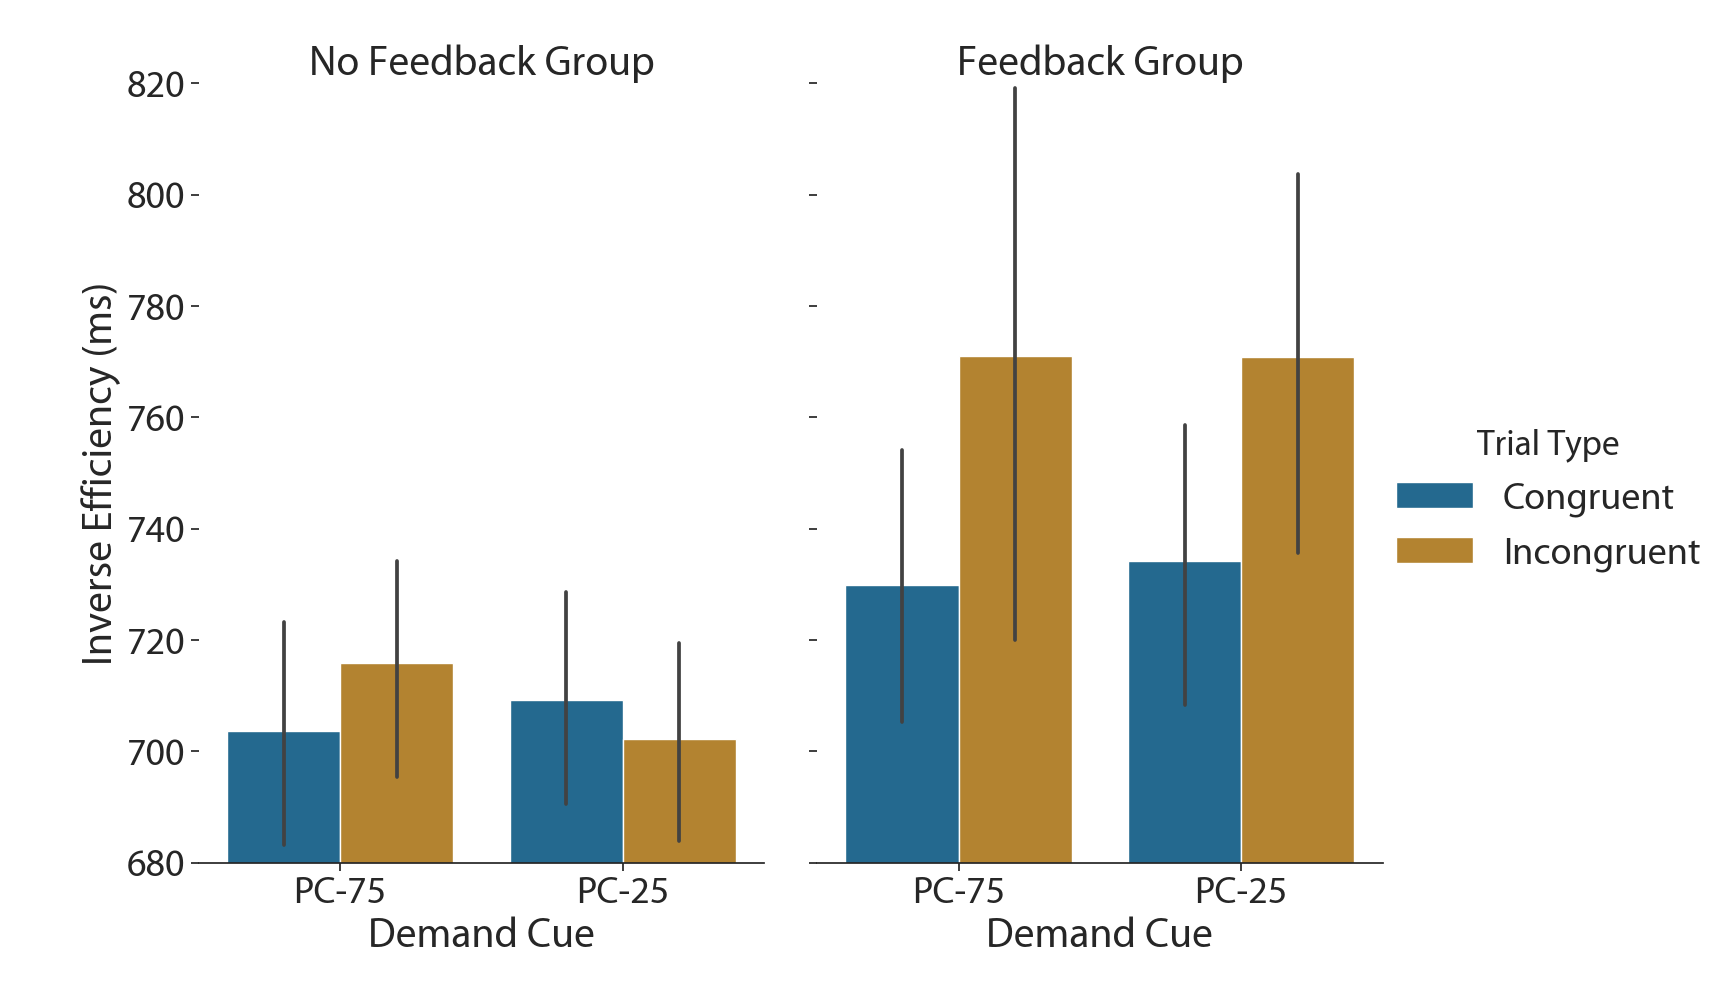

In [420]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-75", "PC-25"],IE_all_T,"Demand Cue","Inverse Efficiency (ms)","Experiment 1a Transfer","Trial Type",680,820,"ISPC_IE_transfertask.png",20)

In [421]:
%%writefile IE_Anova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

rawIEData <- read.csv('IE_Main.csv')

rawIEData$SubjectID = as.factor(rawIEData$SubjectID)
rawIEData$CueType = as.factor(rawIEData$CueType)
rawIEData$TrialType = as.factor(rawIEData$TrialType)
rawIEData$Feedback = as.factor(rawIEData$Feedback)

SC_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SC_RT_runANOVA)

#

rawIEData_T <- read.csv('IE_transfer.csv')

rawIEData_T$SubjectID = as.factor(rawIEData_T$SubjectID)
rawIEData_T$CueType = as.factor(rawIEData_T$CueType)
rawIEData_T$TrialType = as.factor(rawIEData_T$TrialType)
rawIEData_T$Feedback = as.factor(rawIEData_T$Feedback)

SCT_RT_runANOVA <- ezANOVA(data=as.data.frame(rawIEData_T),
                                  dv=.(IE),
                                  wid=.(SubjectID),
                                  within=.(CueType, TrialType),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(SCT_RT_runANOVA)

Overwriting IE_Anova.R


In [422]:
! Rscript IE_Anova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpSqcRFs\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpSqcRFs\downloaded_packages
$ANOVA
                      Effect DFn DFd          SSn       SSd            F
1                (Intercept)   1  58 1.328090e+08 3759315.2 2.049022e+03
2                   Feedback   1  58 7.116212e+03 3759315.2 1.097913e-01
3                    CueType   1  58 1.478164e+04  328897.7 2.606693e+00
5                  TrialType   1  58 8.467813e+04  214192.7 2.292950e+01
4           Feedback:CueType   1  58 1.833803e+03  328897.7 3.233850e-01
6         Feedback:TrialType   1  58 4.846681e+02  214192.7 1.312405e-01
7          CueType:TrialType   1  58 1.483191e+04  110098.3 7.813477e+00
8 Feedback:CueType:TrialType   1  58 1.559973e+02  110098.3 8.217968e-02
           

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


There is an interaction between cue & congruency for inverse efficiency for the main task, but not the transfer task. So that suggests that feedback has little influence on a standard ISPC effect, which we are replicating in both the No Feedback and Feedback groups. It would've been nice to see this occur for transfer too. Alas.

### Now that we've looked at our ANOVAs, let's calculate the means to report in the manuscript

In [423]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Transfer']=='MainTask'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#main effect of PC for RT
maineffectPC=cdat.loc[cdat['Transfer']=='MainTask'].groupby(['subject','DemandCue'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
grpmean, grpmean[1] - grpmean[0]

#for 3-way interaction:
mean_cueing_effect(cdat, 'RT', 'NoFeedback', 'MainTask',1)
mean_cueing_effect(cdat, 'RT', 'Feedback', 'MainTask',1)

(Congruency
 Congruent      651.240149
 Incongruent    660.346722
 Name: RT, dtype: float64, 9.106572350914007)

(DemandCue
 PC-25    655.427505
 PC-75    656.205545
 Name: RT, dtype: float64, 0.7780397957269543)

(ContextCong
 HighC     652.304565
 HighIC    660.724298
 LowC      658.414658
 LowIC     672.518533
 Name: RT, dtype: float64, ContextCong
 HighC     5.282961
 HighIC    5.393084
 LowC      6.419817
 LowIC     6.457948
 Name: RT, dtype: float64)

(ContextCong
 HighC     640.196887
 HighIC    656.606612
 LowC      647.700456
 LowIC     658.694217
 Name: RT, dtype: float64, ContextCong
 HighC     4.411210
 HighIC    4.737006
 LowC      4.337496
 LowIC     4.452076
 Name: RT, dtype: float64)

In [424]:
#main effect of congruency for Accuracy
maineffectcongruency=adat.loc[adat['Transfer']=='MainTask'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean, grpmean[1] - grpmean[0]

#PC x congruency interaction
PCconginteraction=adat.loc[adat['Transfer']=='MainTask'].groupby(['subject','ContextCong'])['Accuracy'].mean()
grpmean = pd.Series.mean(PCconginteraction, level=1)
grpmean, (grpmean[1] - grpmean[0])*100, (grpmean[3] - grpmean[2])*100

(Congruency
 Congruent      0.909204
 Incongruent    0.891345
 Name: Accuracy, dtype: float64, -0.01785926144234451)

(ContextCong
 HighC     0.907163
 HighIC    0.896806
 LowC      0.909858
 LowIC     0.875150
 Name: Accuracy, dtype: float64, -1.0357082931560901, -3.4707841909639714)

In [425]:
#main effect of congruency for IE - it's all alreaydy subject specific, so I don't need to do pd.series.mean (which treats each row like a subj)
maineffectcongruency=IE_all.groupby(['TrialType'])['IE'].mean()
maineffectcongruency

#PC x congruency interaction
PCcongint = IE_all.groupby(['SubjectID', 'Feedback'])['Effect'].mean()
grpmean = pd.Series.mean(PCcongint, level=1)
grpmean

TrialType
Congruent      725.105235
Incongruent    762.672537
Name: IE, dtype: float64

Feedback
NoFeedback    34.669971
Feedback      28.220220
Name: Effect, dtype: float64

In [426]:
#no significant effects for transfer - PC effects for each group are...
PCbyfb=IE_all_T.groupby(['Feedback'])['Effect'].mean()
PCbyfb

Feedback
Feedback       4.359069
NoFeedback    19.334183
Name: Effect, dtype: float64

### Is there a correlation between the main ISPC effect and the transfer effect?

In Bugg and Dey (2018), this correlation was fairly small and observed when the N was large (i.e., across many expts). We may not see anything "stable" here for the No Feedback group (more comparable to Bugg and Dey, 2018), because our sample size is relatively small. Note that this is just an exploratory analysis that I was curious about, given the lack of a group-level transfer effect (e.g., if not observed at the group-level, are there individual differences?).

In [427]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue):
    sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=2, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

INVERSE EFFICIENCY

for the feedback group...?

<IPython.core.display.Javascript object>


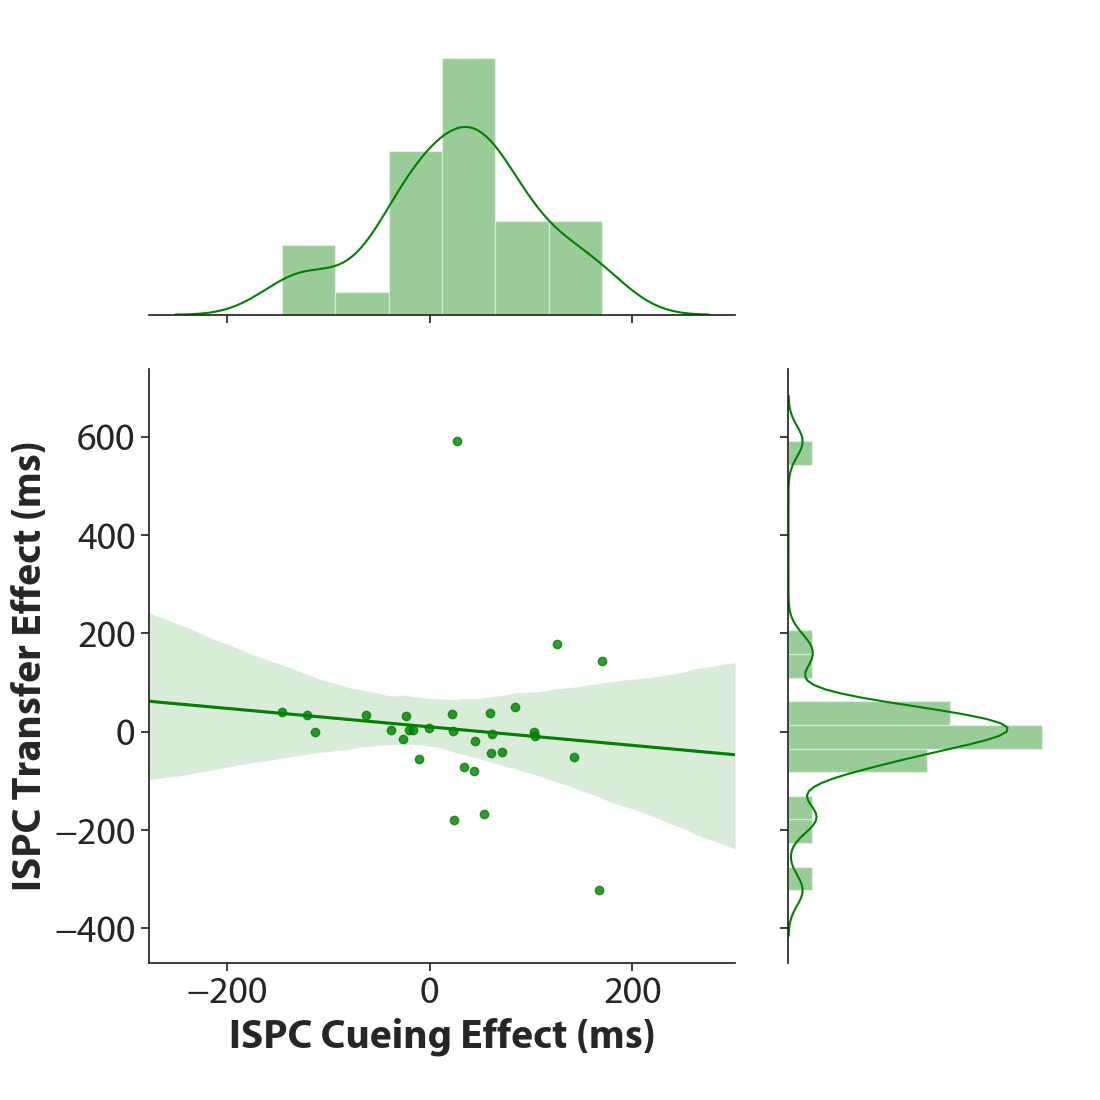

(LinregressResult(slope=-0.18824995134056474, intercept=9.671524145621312, rvalue=-0.10334957330388557, pvalue=0.586803022829504, stderr=0.3423854609126476),
 LinregressResult(slope=-0.12432548795835092, intercept=0.0025456869713780875, rvalue=-0.08863224843515036, pvalue=0.6413948962922702, stderr=0.2640443119140717))

In [428]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="Feedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE_FB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="Feedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].OverallIE)

for the no feedback group...?

<IPython.core.display.Javascript object>


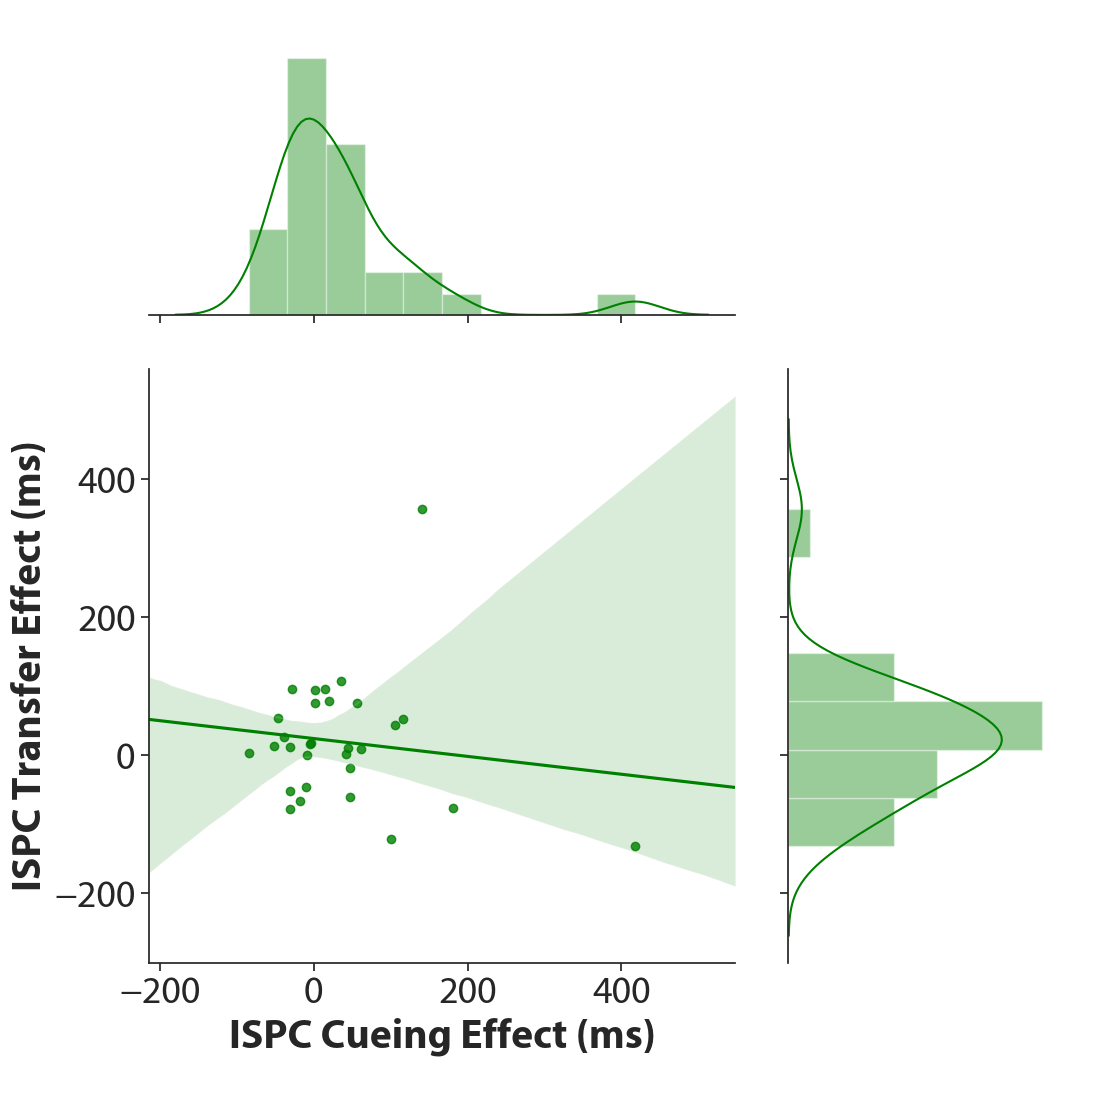

(LinregressResult(slope=-0.12949229158958742, intercept=23.82367747027977, rvalue=-0.1351980805614943, pvalue=0.4762630785569967, stderr=0.179344689496972),
 LinregressResult(slope=-0.1451814628344077, intercept=0.03128291226912609, rvalue=-0.13942439675814097, pvalue=0.46245495176549145, stderr=0.19486356795918483))

In [429]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE_NoFB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].OverallIE)

for all subjects...?

<IPython.core.display.Javascript object>


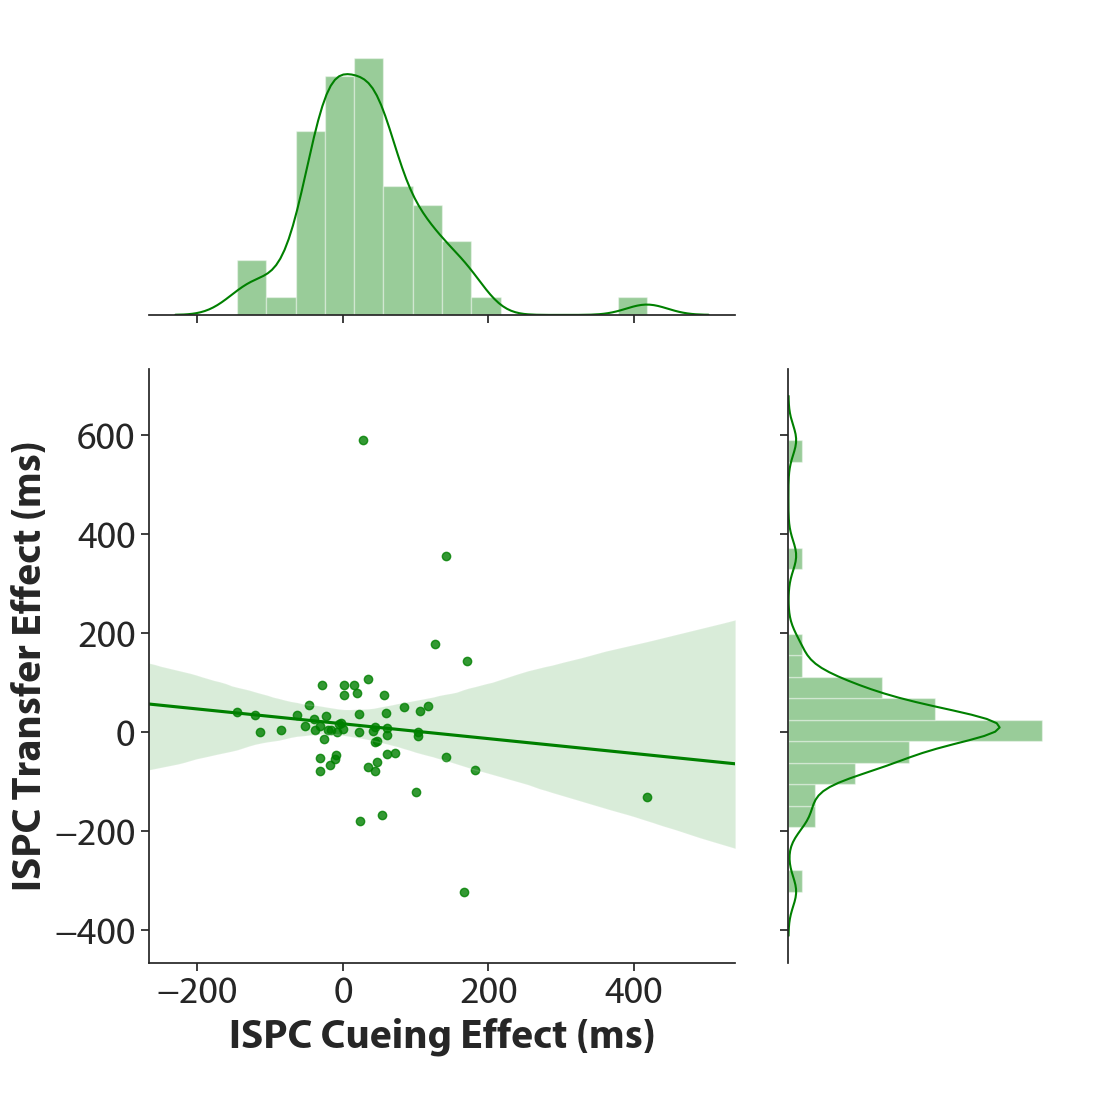

(LinregressResult(slope=-0.14998968642084698, intercept=16.563066301361328, rvalue=-0.1087343912555995, pvalue=0.40824194778707057, stderr=0.1800519406798603),
 LinregressResult(slope=-0.13341853547278845, intercept=0.01684811257714603, rvalue=-0.10880263227297271, pvalue=0.4079460736177638, stderr=0.1600577994068421))

In [430]:
my_corr_graphs(avgIEmain.Effect, avgIE_T.Effect, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All_IE.png", 1, avgIEmain.OverallIE, avgIE_T.OverallIE)

REACTION TIME

for the feedback group...?

<IPython.core.display.Javascript object>


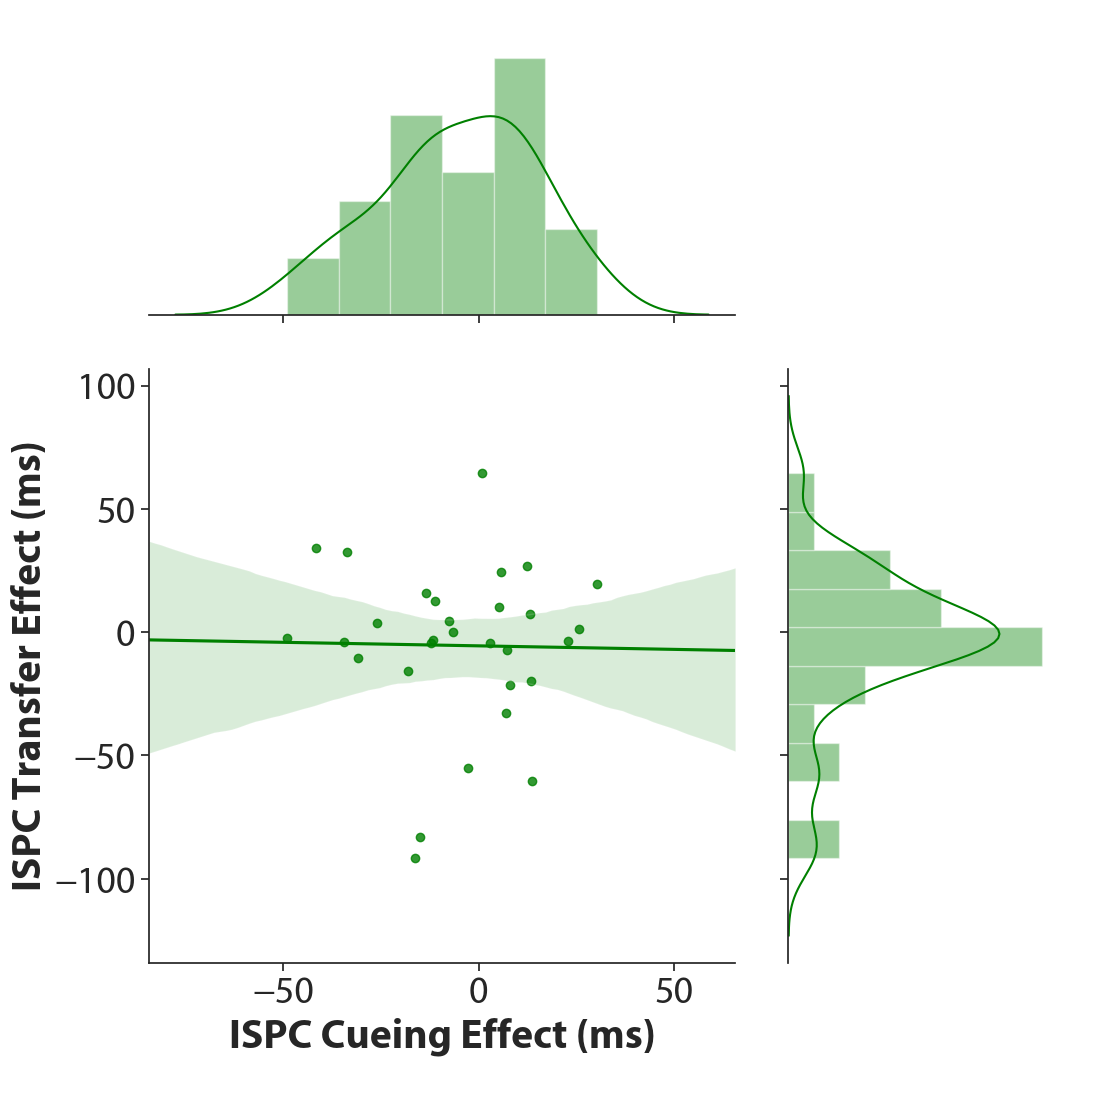

(LinregressResult(slope=-0.028627371204236217, intercept=-5.536946573199995, rvalue=-0.01731026607072158, pvalue=0.9276593609221144, stderr=0.31248820800009003),
 LinregressResult(slope=-0.02861099059574978, intercept=-0.007587335723960316, rvalue=-0.017660925830427582, pvalue=0.9261978512607568, stderr=0.30610658457458945))

In [431]:
my_corr_graphs(SC_RT_FB.RTs, SCT_RT_FB.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_FB.png", 1, MainRT_FB.RT, RT_FB_T.RT)

for the no feedback group...?

<IPython.core.display.Javascript object>


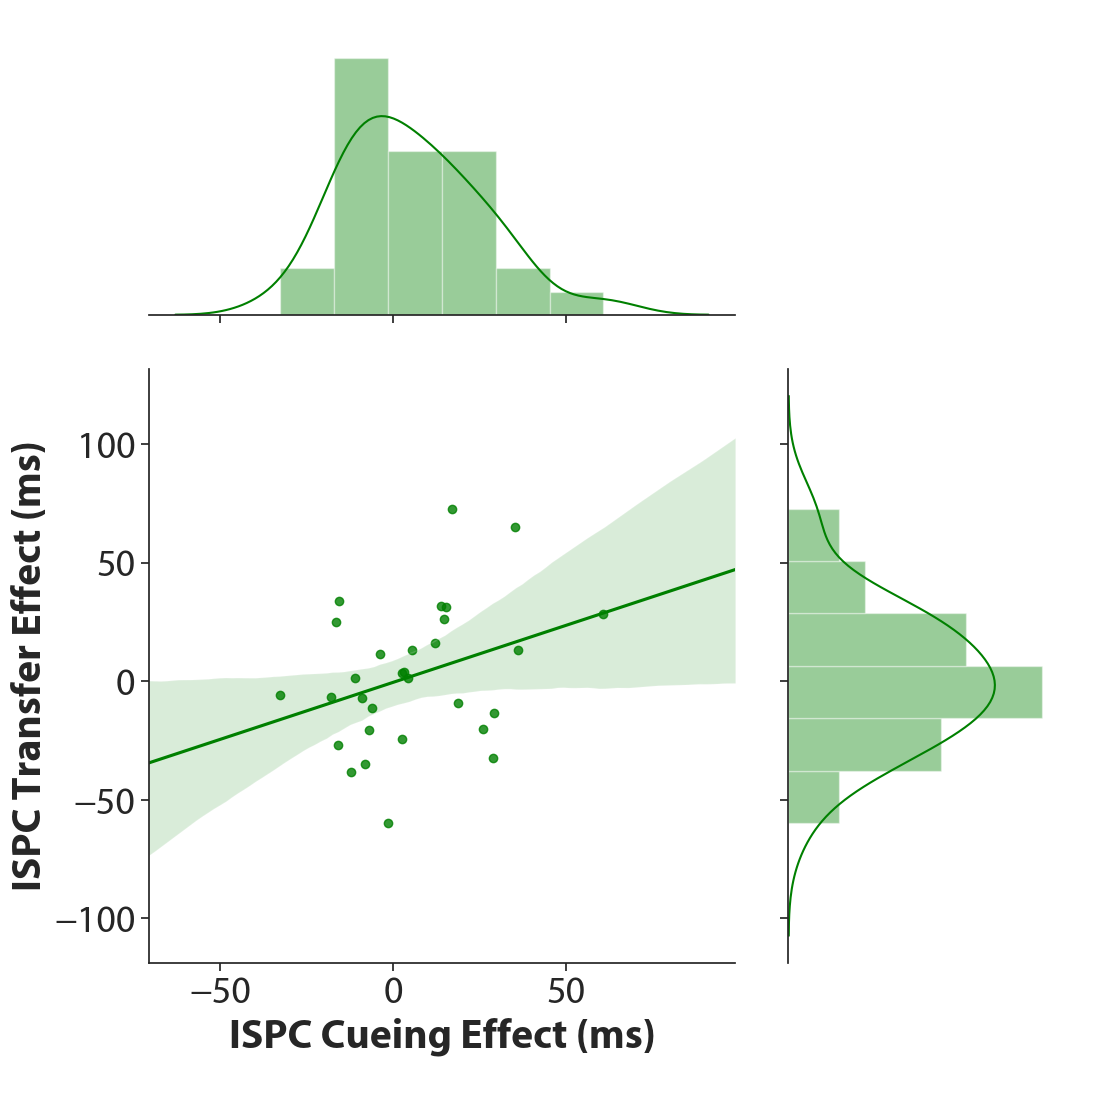

(LinregressResult(slope=0.480942370419758, intercept=-0.531170365931187, rvalue=0.3289977722263559, pvalue=0.07586166884353994, stderr=0.2608826361242858),
 LinregressResult(slope=0.509552425818911, intercept=-0.001271367686481453, rvalue=0.33949667404647693, pvalue=0.06644180148506286, stderr=0.2667980542998494))

In [432]:
my_corr_graphs(SC_RT_NoFB.RTs, SCT_RT_NoFB.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_NoFB.png", 1, MainRT_NoFB.RT, RT_NoFB_T.RT)

across all subjects...?

<IPython.core.display.Javascript object>


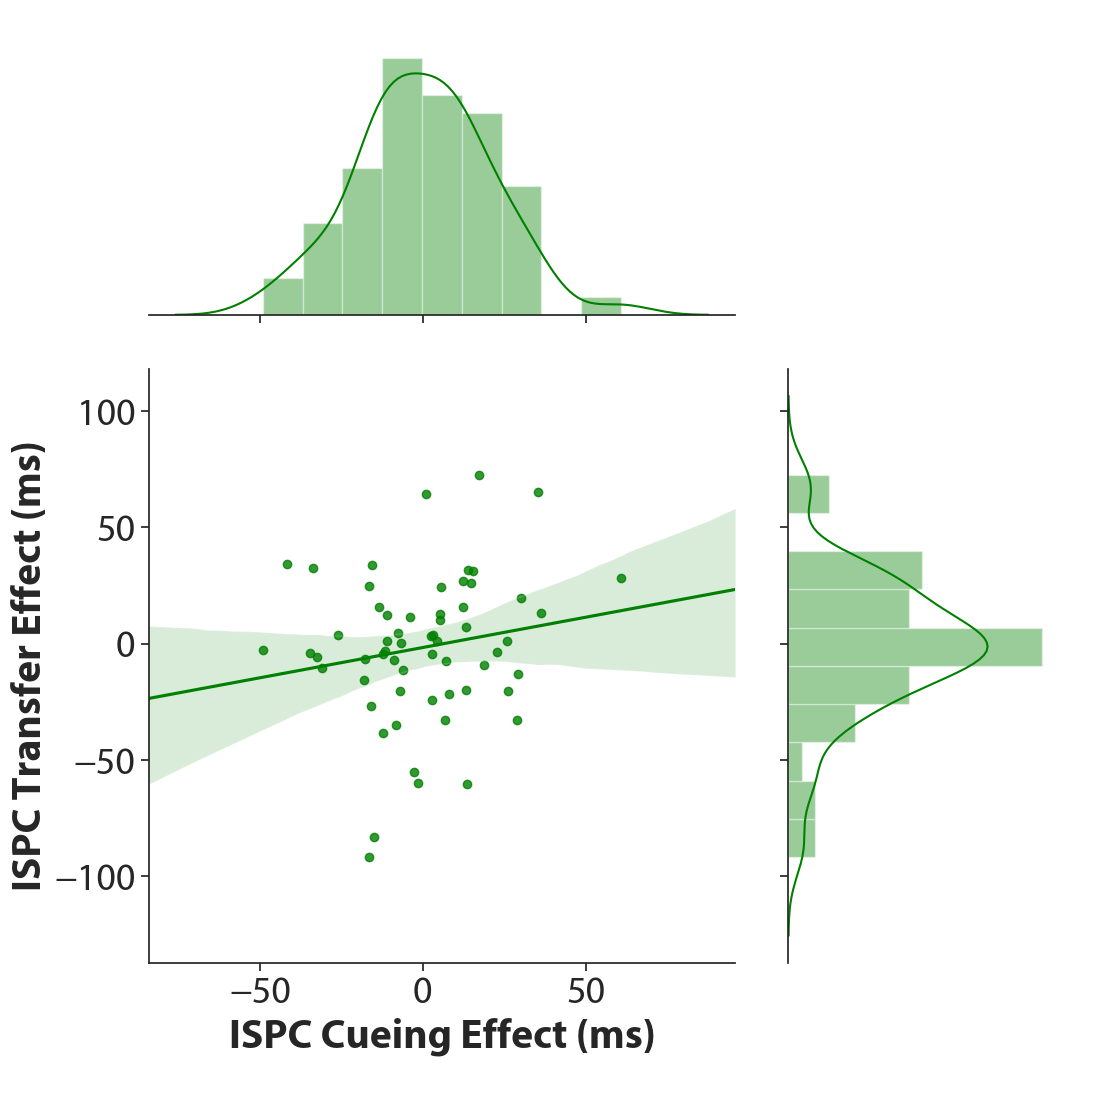

(LinregressResult(slope=0.2601652768680186, intercept=-1.6245490363864132, rvalue=0.17184050211774676, pvalue=0.18922991282225654, stderr=0.1958398413162108),
 LinregressResult(slope=0.27423828427431435, intercept=-0.002170128334189682, rvalue=0.18132851969119615, pvalue=0.16558119570020718, stderr=0.19529366033149756))

In [433]:
my_corr_graphs(SC_RT.RTs, SCT_RT.RTs, 'ISPC Transfer Effect (ms)', 'ISPC Cueing Effect (ms)', "SC_SCT_All.png", 0, overallMainRT.RT, overallRT_T.RT)

So, there is some hint of a correlation between the cueing & transfer effects for RT, for the no feedback group, consistent with Bugg & Dey (2018), but I would not really trust the trending correlation with only 30 participants in that group.

ACCURACY

... for the feedback group?

<IPython.core.display.Javascript object>


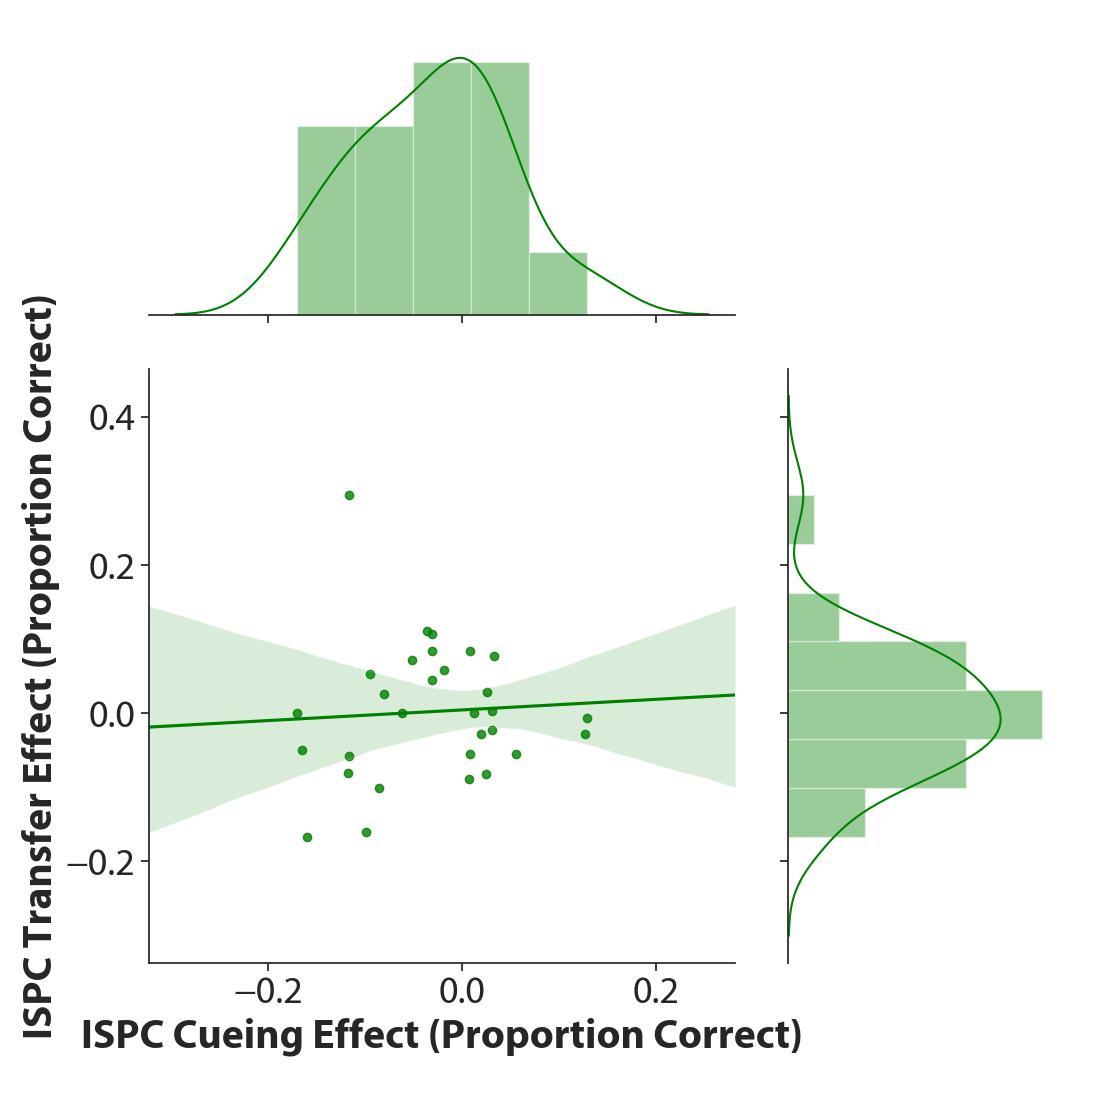

(LinregressResult(slope=0.07161129188115062, intercept=0.004247017846015845, rvalue=0.06101118749765317, pvalue=0.7487628621113638, stderr=0.22140284919515554),
 LinregressResult(slope=0.044916039484191976, intercept=0.004246203889131963, rvalue=0.03668521187190789, pvalue=0.8473821046480372, stderr=0.23122722810775692))

In [434]:
my_corr_graphs(SC_ACC_FB.ACC, SCT_ACC_FB.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_FB_ACC.png", 1, MainACC_FB.Accuracy, ACC_FB_T.Accuracy)

... for the no feedback group?

<IPython.core.display.Javascript object>


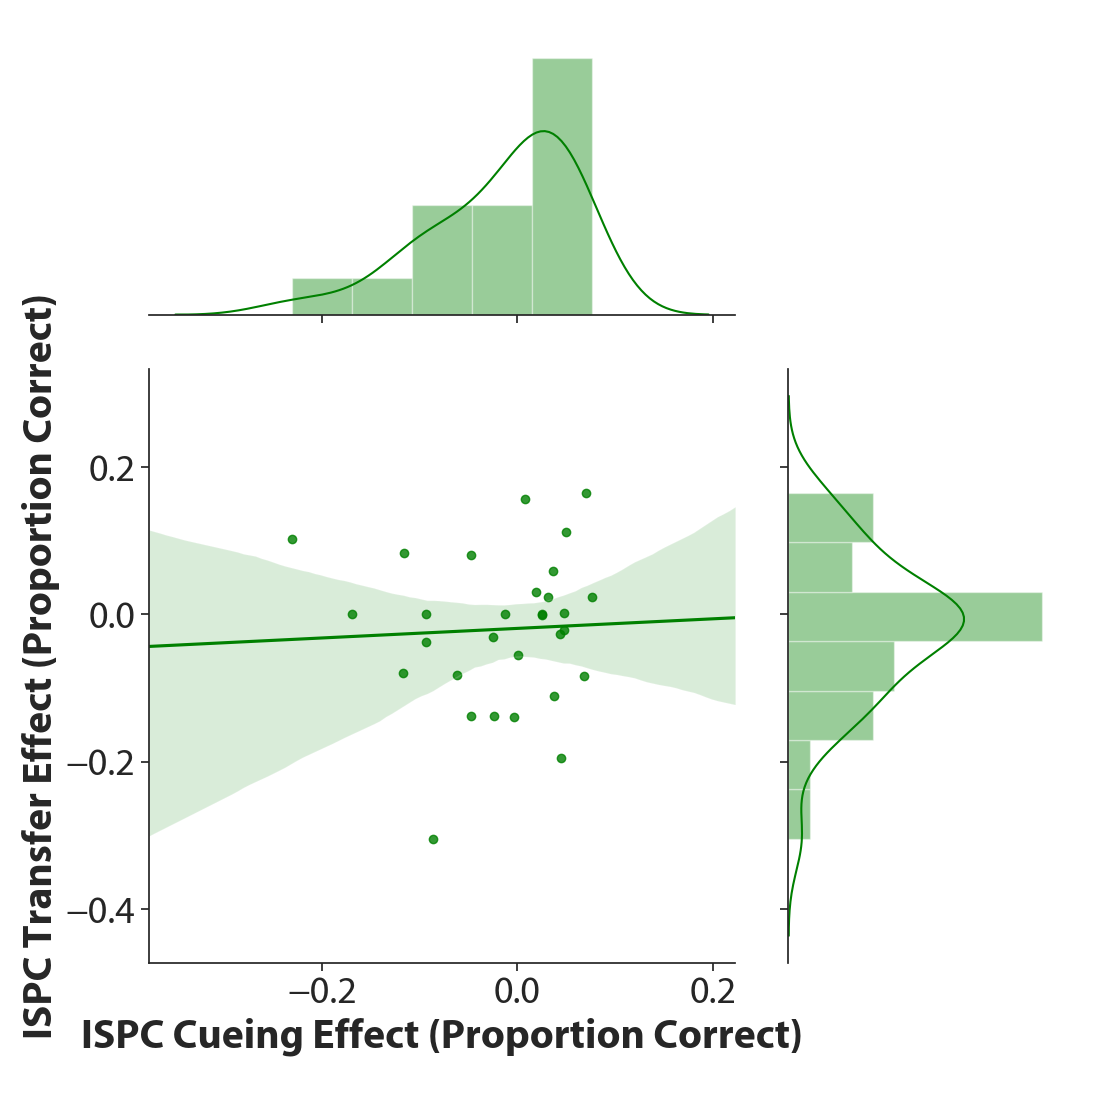

(LinregressResult(slope=0.06487964737698938, intercept=-0.019113687774429036, rvalue=0.047823286042152524, pvalue=0.8018511008851036, stderr=0.25609013672876085),
 LinregressResult(slope=0.05783616646882538, intercept=-0.02082663544918925, rvalue=0.04386869954868424, pvalue=0.8179522602247038, stderr=0.2489129137772412))

In [435]:
my_corr_graphs(SC_ACC_NoFB.ACC, SCT_ACC_NoFB.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_NoFB_ACC.png", 1, MainACC_NoFB.Accuracy, ACC_NoFB_T.Accuracy)

... for all subjects?

<IPython.core.display.Javascript object>


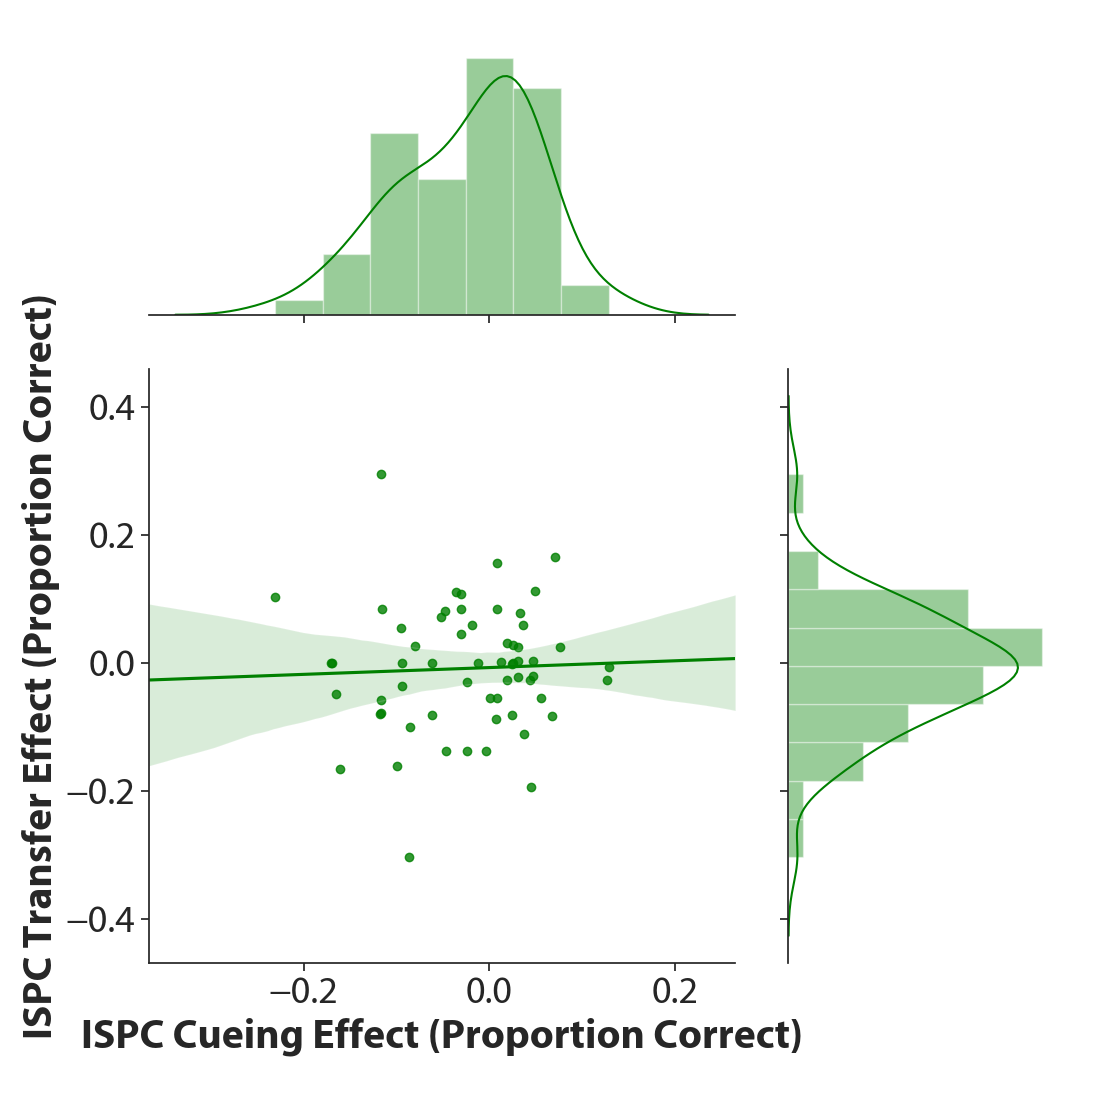

(LinregressResult(slope=0.053021133451115116, intercept=-0.007829801779494001, rvalue=0.04181602518711047, pvalue=0.7510685938485433, stderr=0.16634594954010826),
 LinregressResult(slope=0.0384834431167258, intercept=-0.008616950971398968, rvalue=0.030211142085855087, pvalue=0.8187569706777311, stderr=0.167183917541148))

In [436]:
my_corr_graphs(SC_ACC.ACC, SCT_ACC.ACC, 'ISPC Transfer Effect (Proportion Correct)', 'ISPC Cueing Effect (Proportion Correct)', "SC_SCT_All_ACC.png", 0, overallMainACC.Accuracy, overallACC_T.Accuracy)

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [437]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=2)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [438]:
def ci_effects(df, dv, Filter1, Filter2, Context):
    if Context == 1:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Transfer']==Filter2].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
   
    return sub_means

In [439]:
def make_ci_table(df, dv, Filter1, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Filter1, Filter2, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Filter1, Filter2, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)

    x2 = ci_effects(df, dv, Filter1, Filter3, Context);
    r4_MIC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighIC'][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'HighC'][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowIC'][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x2.loc[x2['ContextCong'] == 'LowC'][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1 (Main)': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2 (Main)': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3 (Main)': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Overall (Main)': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC],
                     'Run 4 (Transfer)': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

First, let's look at the typical ISPC paradigm group.

In [440]:
make_ci_table(cdat, 'RT', 'NoFeedback', 'MainTask', 'TransferTask', 1, 2, 0, 'NoFBSupplementaryTable1.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(665.0, [639.0, 690.0])","(656.0, [628.0, 684.0])","(655.0, [627.0, 682.0])","(658.0, [632.0, 685.0])","(649.0, [623.0, 676.0])"
1,MC.IC,"(682.0, [655.0, 710.0])","(671.0, [642.0, 700.0])","(666.0, [639.0, 693.0])","(673.0, [646.0, 699.0])","(654.0, [629.0, 680.0])"
2,MIC.C,"(661.0, [637.0, 685.0])","(648.0, [623.0, 673.0])","(650.0, [630.0, 670.0])","(652.0, [631.0, 674.0])","(643.0, [620.0, 666.0])"
3,MIC.IC,"(668.0, [645.0, 692.0])","(654.0, [630.0, 677.0])","(660.0, [638.0, 682.0])","(661.0, [639.0, 683.0])","(646.0, [624.0, 668.0])"


And now what about the feedback group for RT?

In [441]:
make_ci_table(cdat, 'RT', 'Feedback', 'MainTask', 'TransferTask', 1, 2, 0, 'FBSupplementaryTable2.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(653.0, [631.0, 675.0])","(645.0, [627.0, 662.0])","(647.0, [630.0, 665.0])","(648.0, [630.0, 665.0])","(648.0, [627.0, 669.0])"
1,MC.IC,"(658.0, [635.0, 681.0])","(661.0, [641.0, 681.0])","(659.0, [638.0, 681.0])","(659.0, [640.0, 677.0])","(648.0, [629.0, 667.0])"
2,MIC.C,"(641.0, [618.0, 663.0])","(641.0, [623.0, 660.0])","(639.0, [621.0, 657.0])","(640.0, [622.0, 658.0])","(643.0, [625.0, 661.0])"
3,MIC.IC,"(661.0, [638.0, 684.0])","(656.0, [638.0, 675.0])","(654.0, [634.0, 674.0])","(657.0, [637.0, 676.0])","(649.0, [629.0, 669.0])"


And for Accuracy, first for the typical ISPC group...

In [442]:
make_ci_table(adat, 'Accuracy', 'NoFeedback', 'MainTask', 'TransferTask', 1, 2, 1, 'NoFB_ACC_SupplementaryTable3.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(0.92, [0.9, 0.95])","(0.92, [0.9, 0.95])","(0.93, [0.91, 0.95])","(0.92, [0.9, 0.95])","(0.93, [0.91, 0.95])"
1,MC.IC,"(0.89, [0.84, 0.95])","(0.88, [0.82, 0.93])","(0.92, [0.89, 0.96])","(0.9, [0.86, 0.94])","(0.92, [0.9, 0.95])"
2,MIC.C,"(0.91, [0.88, 0.95])","(0.9, [0.84, 0.97])","(0.93, [0.9, 0.97])","(0.92, [0.88, 0.95])","(0.92, [0.89, 0.94])"
3,MIC.IC,"(0.9, [0.86, 0.94])","(0.89, [0.83, 0.96])","(0.93, [0.9, 0.96])","(0.91, [0.87, 0.94])","(0.93, [0.9, 0.95])"


And now for the feedback group...

In [443]:
make_ci_table(adat, 'Accuracy', 'Feedback', 'MainTask', 'TransferTask', 1, 2, 1, 'FB_ACC_SupplementaryTable4.csv')

,Context.TrialType,Run 1 (Main),Run 2 (Main),Run 3 (Main),Overall (Main),Run 4 (Transfer)
0,MC.C,"(0.88, [0.82, 0.93])","(0.9, [0.86, 0.94])","(0.91, [0.88, 0.94])","(0.89, [0.86, 0.93])","(0.9, [0.87, 0.94])"
1,MC.IC,"(0.8, [0.72, 0.87])","(0.88, [0.83, 0.92])","(0.88, [0.85, 0.92])","(0.85, [0.82, 0.89])","(0.88, [0.84, 0.93])"
2,MIC.C,"(0.9, [0.86, 0.95])","(0.89, [0.84, 0.93])","(0.91, [0.87, 0.95])","(0.9, [0.86, 0.94])","(0.89, [0.85, 0.93])"
3,MIC.IC,"(0.87, [0.82, 0.91])","(0.9, [0.86, 0.94])","(0.9, [0.86, 0.94])","(0.89, [0.85, 0.92])","(0.87, [0.82, 0.92])"


# Post-test Questionnaire Data

This was to assess participant awareness of the task manipulations.

In [444]:
%cd ..

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispc\data


In [445]:
posttest = pd.read_csv('posttest.csv')

In [446]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [447]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences.

<IPython.core.display.Javascript object>


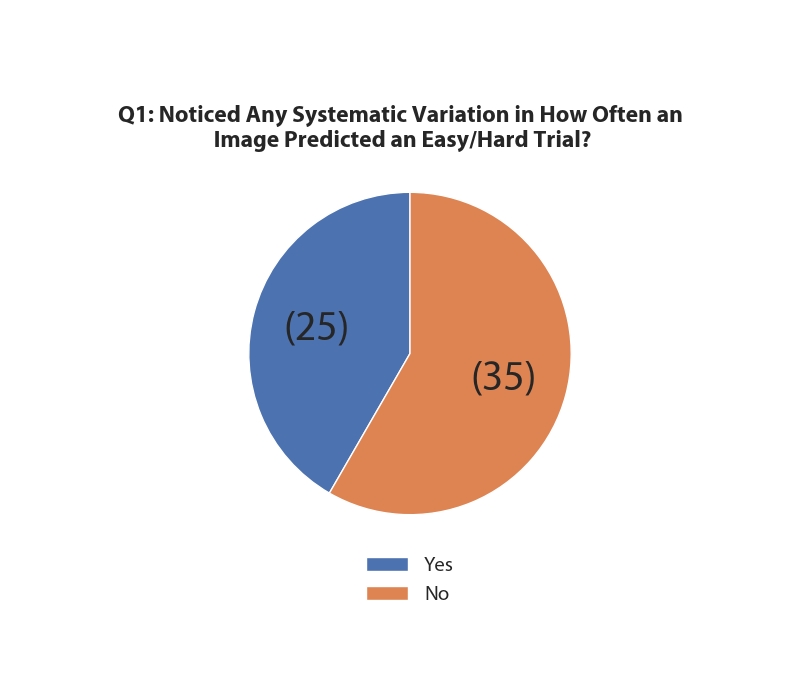

In [448]:
fig, ax1 = plt.subplots(figsize=(8, 7));
Q1 = [posttest.Q1_SC_SystematicVariation[posttest.Q1_SC_SystematicVariation == 1].count(), posttest.Q1_SC_SystematicVariation[posttest.Q1_SC_SystematicVariation == 0].count()];
Q1labels = ['Yes','No'];
plt.axis('equal');
startanglept=90;
radiussize=0.65;
legendfontsize=15;
titlefontsize=17;

patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
fig.suptitle('Q1: Noticed Any Systematic Variation in How Often an\n Image Predicted an Easy/Hard Trial?', fontsize=titlefontsize,fontweight="bold", y = 0.85);
plb.savefig(figurepath+"posttestQ1_SC.png", bbox_inches='tight');

#### Next, we asked participants to rate how likely certain images would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were the bear and bird paired together? Bear and deer? Bear and turtle?

Were any of the image category pairings rated as more predictive or nonpredictive than chance (50%)?

In [449]:
ttest = stats.ttest_1samp(posttest.Q2_BearTurtle.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.Q2_BearTurtle.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=1.7129708152899774, pvalue=0.09360086726347833),
 0.25256376784260326)

In [450]:
ttest = stats.ttest_1samp(posttest.Q2_BearBird.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.Q2_BearBird.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-0.3019612429581736, pvalue=0.7640728052612893),
 -0.04452175634471728)

In [451]:
ttest = stats.ttest_1samp(posttest.Q2_BearDeer.dropna(),50)
cohens_dz = ttest[0] / sqrt(len(posttest.Q2_BearDeer.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=0.6680482316031405, pvalue=0.5075149412291011),
 0.09849833807338682)

In versions 1 and 7, the bear and turtle were paired together (as the mostly congruent context).
In versions 2 and 8, the bear and deer were paired together (as the mostly congruent context).
In versions 3 and 9, the bear and turtle were paired together (as the mostly incongruent context).
In versions 4 and 10, the bear and deer were paired together (as the mostly incongruent context).
In versions 5 and 11, the bear and bird were paired together (as the mostly congruent context).
In versions 6 and 12, the bear and bird were paired together (as the mostly incongruent context).

In [452]:
posttest['Group'] = posttest['version'].isin([1,2,3,4])
posttest.loc[posttest['version'].isin([1,7,3,9]),'Group'] = 'BearTurtle'
posttest.loc[posttest['version'].isin([2,8,4,10]),'Group'] = 'BearDeer'
posttest.loc[posttest['version'].isin([5,6,11,12]),'Group'] = 'BearBird'

Does any one group differ in how it rates the image categories? E.g., the "BearDeer" group could rate the bear + deer clustering as more predictive than the other 2 groups.

In [453]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod_BT = ols('Q2_BearTurtle ~ Group',
                data=posttest).fit()
                
aov_table_BT = sm.stats.anova_lm(mod_BT, typ=2)
print(aov_table_BT)

                sum_sq    df         F    PR(>F)
Group       706.337104   2.0  1.118349  0.336138
Residual  13579.162896  43.0       NaN       NaN


In [454]:
posttest.groupby(['Group'])['Q2_BearTurtle'].mean()

Group
BearBird      50.250000
BearDeer      60.153846
BearTurtle    54.176471
Name: Q2_BearTurtle, dtype: float64

In [455]:
mod_BB = ols('Q2_BearBird ~ Group',
                data=posttest).fit()
                
aov_table_BB = sm.stats.anova_lm(mod_BB, typ=2)
print(aov_table_BB)

                sum_sq    df         F    PR(>F)
Group      1949.524629   2.0  2.469042  0.096591
Residual  16976.127545  43.0       NaN       NaN


In [456]:
posttest.groupby(['Group'])['Q2_BearBird'].mean()

Group
BearBird      43.437500
BearDeer      59.230769
BearTurtle    46.647059
Name: Q2_BearBird, dtype: float64

In [457]:
mod_BD = ols('Q2_BearDeer ~ Group',
                data=posttest).fit()
                
aov_table_BD = sm.stats.anova_lm(mod_BD, typ=2)
print(aov_table_BD)

                sum_sq    df         F   PR(>F)
Group       382.779203   2.0  0.406575  0.66846
Residual  20241.677319  43.0       NaN      NaN


In [458]:
posttest.groupby(['Group'])['Q2_BearDeer'].mean()

Group
BearBird      48.187500
BearDeer      54.692308
BearTurtle    53.823529
Name: Q2_BearDeer, dtype: float64

In [459]:
GRP_BT = posttest.groupby(['subjID'])['Q2_BearTurtle'].mean()
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = posttest.groupby(['subjID'])['Q2_BearBird'].mean()
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = posttest.groupby(['subjID'])['Q2_BearDeer'].mean()
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))

C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


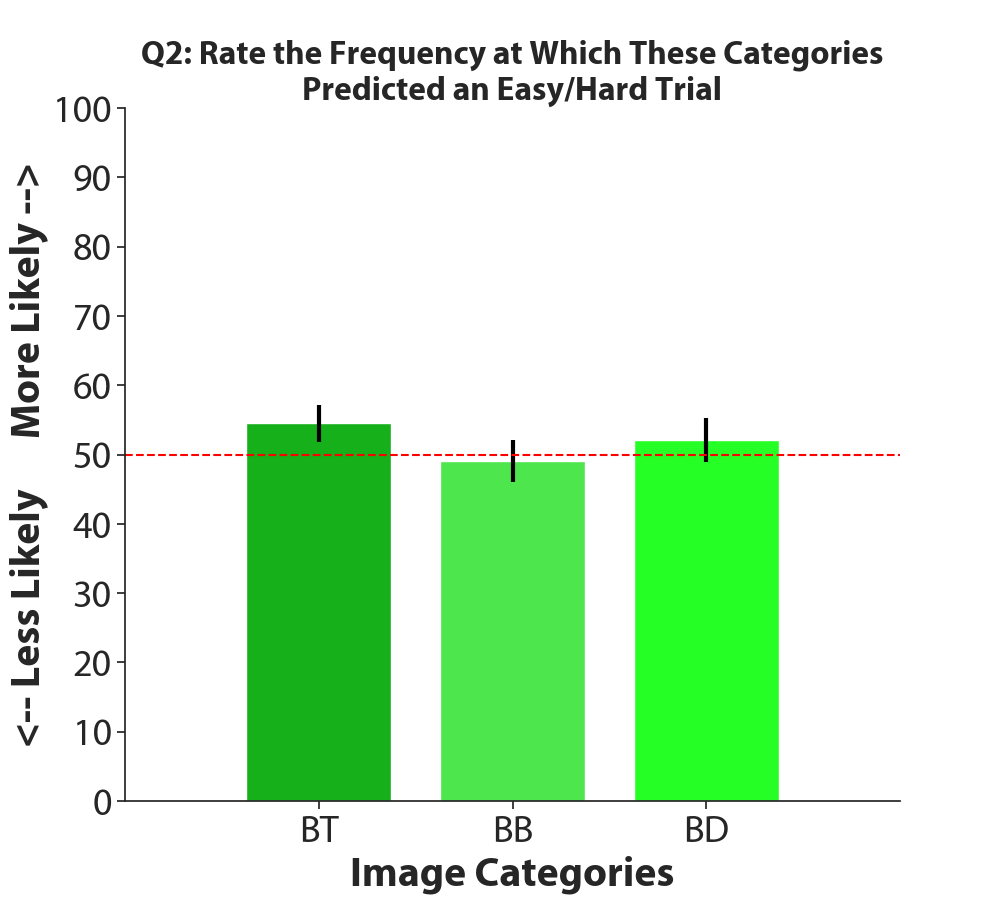

In [485]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 9));
plt.plot([0,1,2,3,4],[50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.3,0.9,0.3),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,4);
ax.set_xticklabels(('BT','BB','BD'));
ax.set_xticks([1, 2, 3]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which These Categories\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Image Categories',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the images to the Stroop trial type that they most likely predicted. Did they perform better than chance (i.e., 2/4 cue-demand relationships correctly matched)? They were asked this for both the main task ISPC items (SC_ForcedChoice) and the transfer task items (SCT_ForcedChoice). We can then compare their performance matching between the transfer items (which were nonpredictive) and the main task items (which were predictive).

In [461]:
ttest = stats.ttest_1samp(posttest.Q3_SC_ForcedChoicePerformance.dropna(),2)
cohens_dz = ttest[0] / sqrt(len(posttest.Q3_SC_ForcedChoicePerformance.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=0.8425417160057262, pvalue=0.4038443298545157),
 0.12289734024179676)

In [462]:
ttest = stats.ttest_1samp(posttest.Q3_SCT_ForcedChoicePerformance.dropna(),2)
cohens_dz = ttest[0] / sqrt(len(posttest.Q3_SCT_ForcedChoicePerformance.dropna()))
ttest, cohens_dz

(Ttest_1sampResult(statistic=-0.4536137206419928, pvalue=0.6522397151888728),
 -0.06616636150477259)

In [463]:
ttest = stats.ttest_rel(posttest.Q3_SC_ForcedChoicePerformance.dropna(), posttest.Q3_SCT_ForcedChoicePerformance.dropna())
d = cohen_d(posttest.Q3_SC_ForcedChoicePerformance.dropna(), posttest.Q3_SCT_ForcedChoicePerformance.dropna())
ttest, d

(Ttest_relResult(statistic=0.9160920420014967, pvalue=0.36439643420178724),
 0.1857214440378864)

C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


<IPython.core.display.Javascript object>


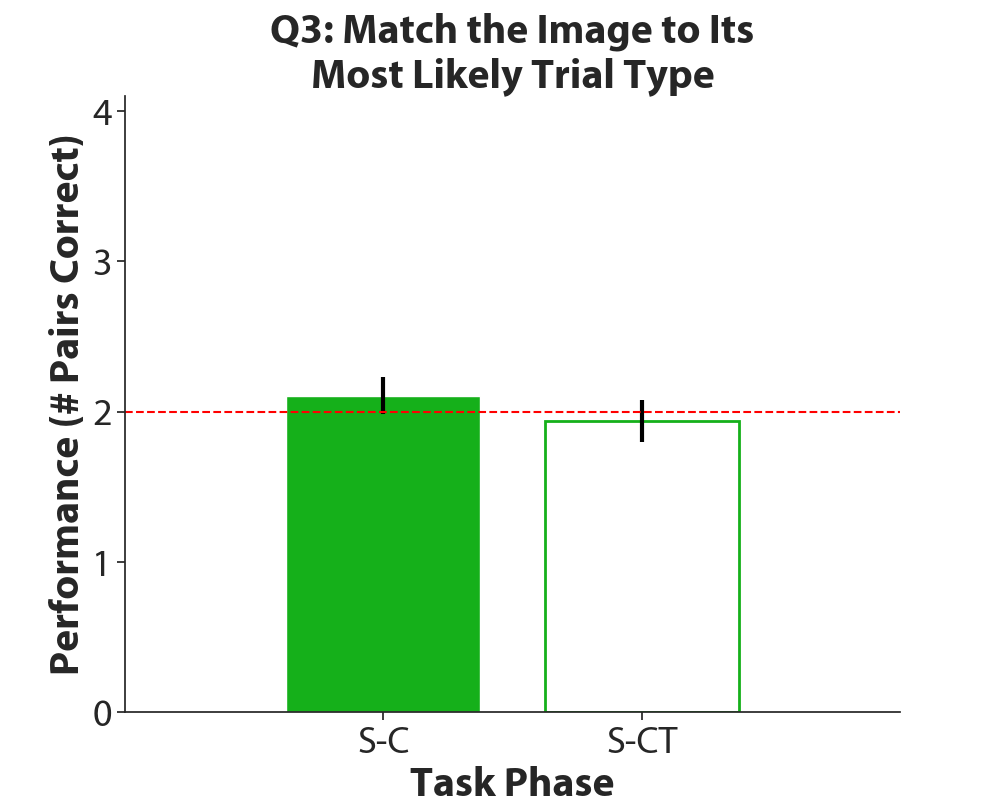

In [486]:
SCFC = posttest.groupby(['subjID'])['Q3_SC_ForcedChoicePerformance'].mean();
SCFCSEM = pd.Series.std(SCFC.dropna()) / sqrt(len(SCFC.dropna()));
SCTFC = posttest.groupby(['subjID'])['Q3_SCT_ForcedChoicePerformance'].mean();
SCTFCSEM = pd.Series.std(SCTFC.dropna()) / sqrt(len(SCTFC.dropna()));

barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 8));
rects1 = ax.bar(1,SCFC.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=SCFCSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(2,SCTFC.dropna().mean(),barwidth,yerr=SCTFCSEM,ecolor='k',edgecolor=sns.xkcd_rgb['green'],linewidth = 2,facecolor='none', error_kw=dict(lw=3));
ax.set_ylim(0,4.1);
ax.set_xlim(0,3);
plt.plot([0,1,2,3],[2,2,2,2], 'r--');
ax.set_xticklabels(('S-C','S-CT'));
ax.set_xticks([1, 2]);
ax.set_yticks(np.arange(0, 5, 1));
plt.title('Q3: Match the Image to Its\nMost Likely Trial Type', fontweight="bold");
plt.ylabel('Performance (# Pairs Correct)', fontweight="bold");
plt.xlabel('Task Phase', fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ3.png", bbox_inches='tight');

# Exploratory Analysis of the Congruency Sequence Effect

This experiment was primarily designed to look at the effects of performance feedback on the ISPC. Here, this is just me satisfying my curiosity with an exploratory analysis of the CSE.

The CSE is also theorized to be sensitive to reward (Abrahamse et al., 2016). Thus, although the trial design is limited (not all the trial types have equal percentages), we can somewhat assess the effects of FB on the CSE.

In [465]:
rdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1) & (TrialCounter != 1)').copy()
acdat = dat.query('(TrialCounter != 1)').copy()

In [466]:
dataframes = [rdat, acdat];

for df in dataframes:
    df['Feedback'] = df['Version'].isin([7,8,9,10,11,12])
    df.loc[df['Version'].isin([7,8,9,10,11,12]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([1,2,3,4,5,6]), 'Feedback'] = 'NoFeedback'
    
    df['Transfer'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2,3]), 'Transfer'] = 'MainTask'
    df.loc[df['RunCounter'].isin([4]), 'Transfer'] = 'TransferTask'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['PrevCong'] = df['Prevtrial'].isin([1])
    df.loc[df['Prevtrial'].isin([1]),'PrevCong'] = 'Incongruent'
    df.loc[~df['Prevtrial'].isin([1]),'PrevCong'] = 'Congruent'
    
    df['CSE'] = df['Sequential'].isin([1])
    df.loc[df['Sequential'].isin([1]),'CSE'] = 'Cong-Cong'
    df.loc[df['Sequential'].isin([2]),'CSE'] = 'Incong-Cong'
    df.loc[df['Sequential'].isin([3]),'CSE'] = 'Cong-Incong'
    df.loc[df['Sequential'].isin([4]),'CSE'] = 'Incong-Incong'

Let's take a peak at the means...

In [467]:
mean_cueing_effect(rdat, 'RT', 'Feedback', 'MainTask',0)

(CSE
 Cong-Cong        648.341186
 Cong-Incong      654.410985
 Incong-Cong      643.393173
 Incong-Incong    660.088898
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.726450
 Cong-Incong      4.520707
 Incong-Cong      4.109320
 Incong-Incong    4.709302
 Name: RT, dtype: float64)

In [468]:
mean_cueing_effect(rdat, 'RT', 'NoFeedback', 'MainTask',0)

(CSE
 Cong-Cong        656.808208
 Cong-Incong      662.729396
 Incong-Cong      656.198395
 Incong-Incong    664.142762
 Name: RT, dtype: float64, CSE
 Cong-Cong        6.119950
 Cong-Incong      5.583867
 Incong-Cong      6.016879
 Incong-Incong    5.713205
 Name: RT, dtype: float64)

In [469]:
mean_cueing_effect(acdat, 'Accuracy', 'Feedback', 'MainTask',0)

(CSE
 Cong-Cong        0.895259
 Cong-Incong      0.881278
 Incong-Cong      0.896117
 Incong-Incong    0.879697
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.008007
 Cong-Incong      0.008640
 Incong-Cong      0.007590
 Incong-Incong    0.008285
 Name: Accuracy, dtype: float64)

In [470]:
mean_cueing_effect(acdat, 'Accuracy', 'NoFeedback', 'MainTask',0)

(CSE
 Cong-Cong        0.921566
 Cong-Incong      0.903948
 Incong-Cong      0.924058
 Incong-Incong    0.905954
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005638
 Cong-Incong      0.007995
 Incong-Cong      0.005826
 Incong-Incong    0.008717
 Name: Accuracy, dtype: float64)

What about transfer?

In [471]:
mean_cueing_effect(rdat, 'RT', 'Feedback', 'TransferTask',0)

(CSE
 Cong-Cong        647.409921
 Cong-Incong      641.589563
 Incong-Cong      643.590979
 Incong-Incong    656.039595
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.731582
 Cong-Incong      4.595183
 Incong-Cong      4.673030
 Incong-Incong    4.931978
 Name: RT, dtype: float64)

In [472]:
mean_cueing_effect(rdat, 'RT', 'NoFeedback', 'TransferTask',0)

(CSE
 Cong-Cong        652.291169
 Cong-Incong      644.499746
 Incong-Cong      640.903025
 Incong-Incong    655.614092
 Name: RT, dtype: float64, CSE
 Cong-Cong        5.734132
 Cong-Incong      5.664214
 Incong-Cong      6.018838
 Incong-Incong    5.468332
 Name: RT, dtype: float64)

In [473]:
mean_cueing_effect(acdat, 'Accuracy', 'Feedback', 'TransferTask',0)

(CSE
 Cong-Cong        0.898744
 Cong-Incong      0.891158
 Incong-Cong      0.898362
 Incong-Incong    0.870480
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.008732
 Cong-Incong      0.011193
 Incong-Cong      0.009472
 Incong-Incong    0.011625
 Name: Accuracy, dtype: float64)

In [474]:
mean_cueing_effect(acdat, 'Accuracy', 'NoFeedback', 'TransferTask',0)

(CSE
 Cong-Cong        0.913105
 Cong-Incong      0.936350
 Incong-Cong      0.931996
 Incong-Incong    0.917806
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005199
 Cong-Incong      0.005397
 Incong-Cong      0.005808
 Incong-Incong    0.004777
 Name: Accuracy, dtype: float64)

OK, let's actually analyze the main task data... Note that there aren't enough trials for transfer analysis.
(Also why this is so exploratory - again the expt was not designed for this.)

In [475]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\ispc\data\csvdata


In [476]:
CSE_RT = rdat.loc[rdat['Transfer'] == 'MainTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC = acdat.loc[acdat['Transfer'] == 'MainTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

CSE_RT_T = rdat.loc[rdat['Transfer'] == 'TransferTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC_T = acdat.loc[acdat['Transfer'] == 'TransferTask'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

#create tidy data csvs
CSE_RT.to_csv(csvpath+'CSE_ANOVA_RT.csv')
CSE_ACC.to_csv(csvpath+'CSE_ANOVA_ACC.csv')
CSE_RT_T.to_csv(csvpath+'CSE_ANOVA_RT_T.csv')
CSE_ACC_T.to_csv(csvpath+'CSE_ANOVA_ACC_T.csv')

In [477]:
%%writefile CSEAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

CSE_RT <- read.csv('CSE_ANOVA_RT.csv')

CSE_RT$subject = as.factor(CSE_RT$subject)
CSE_RT$Feedback = as.factor(CSE_RT$Feedback)
CSE_RT$PrevCong = as.factor(CSE_RT$PrevCong)
CSE_RT$Congruency = as.factor(CSE_RT$Congruency)

CSERT_AN <- ezANOVA(data=as.data.frame(CSE_RT),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSERT_AN)

#

CSE_ACC <- read.csv('CSE_ANOVA_ACC.csv')

CSE_ACC$subject = as.factor(CSE_ACC$subject)
CSE_ACC$Feedback = as.factor(CSE_ACC$Feedback)
CSE_ACC$PrevCong = as.factor(CSE_ACC$PrevCong)
CSE_ACC$Congruency = as.factor(CSE_ACC$Congruency)

CSEACC_AN <- ezANOVA(data=as.data.frame(CSE_ACC),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSEACC_AN)

Overwriting CSEAnova.R


In [478]:
! Rscript CSEAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmp0Y51jZ\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\Rtmp0Y51jZ\downloaded_packages
$ANOVA
                        Effect DFn DFd          SSn        SSd            F
1                  (Intercept)   1  58 1.032064e+08 730904.118 8.189816e+03
2                     Feedback   1  58 4.244826e+03 730904.118 3.368430e-01
3                     PrevCong   1  58 8.818036e+00   5286.249 9.675028e-02
5                   Congruency   1  58 5.031885e+03  17792.271 1.640315e+01
4            Feedback:PrevCong   1  58 2.034411e-02   5286.249 2.232128e-04
6          Feedback:Congruency   1  58 2.970355e+02  17792.271 9.682889e-01
7          PrevCong:Congruency   1  58 5.999994e+02   9240.753 3.765923e+00
8 Feedback:PrevCong:Congruency   1  58 2.775272e+02   9240.7

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Let's look at the graphs...

<IPython.core.display.Javascript object>


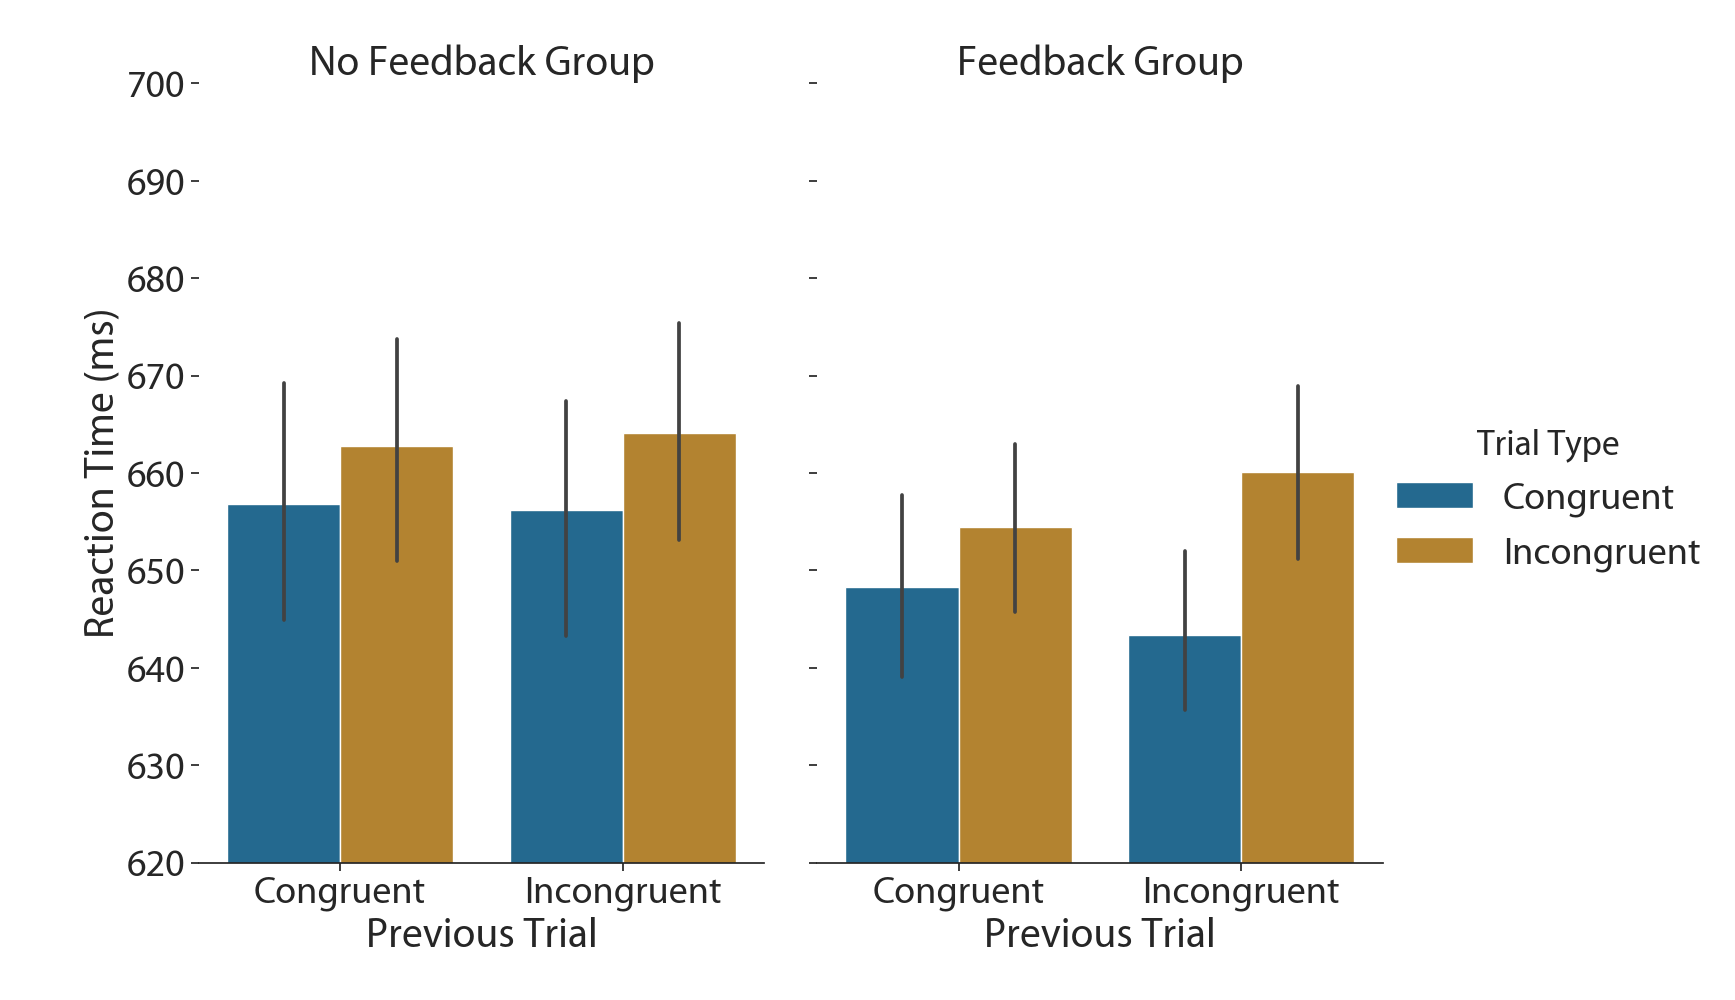

In [479]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect for FB Grps","Trial Type",620,700,"CSE_RT.png",10)

<IPython.core.display.Javascript object>


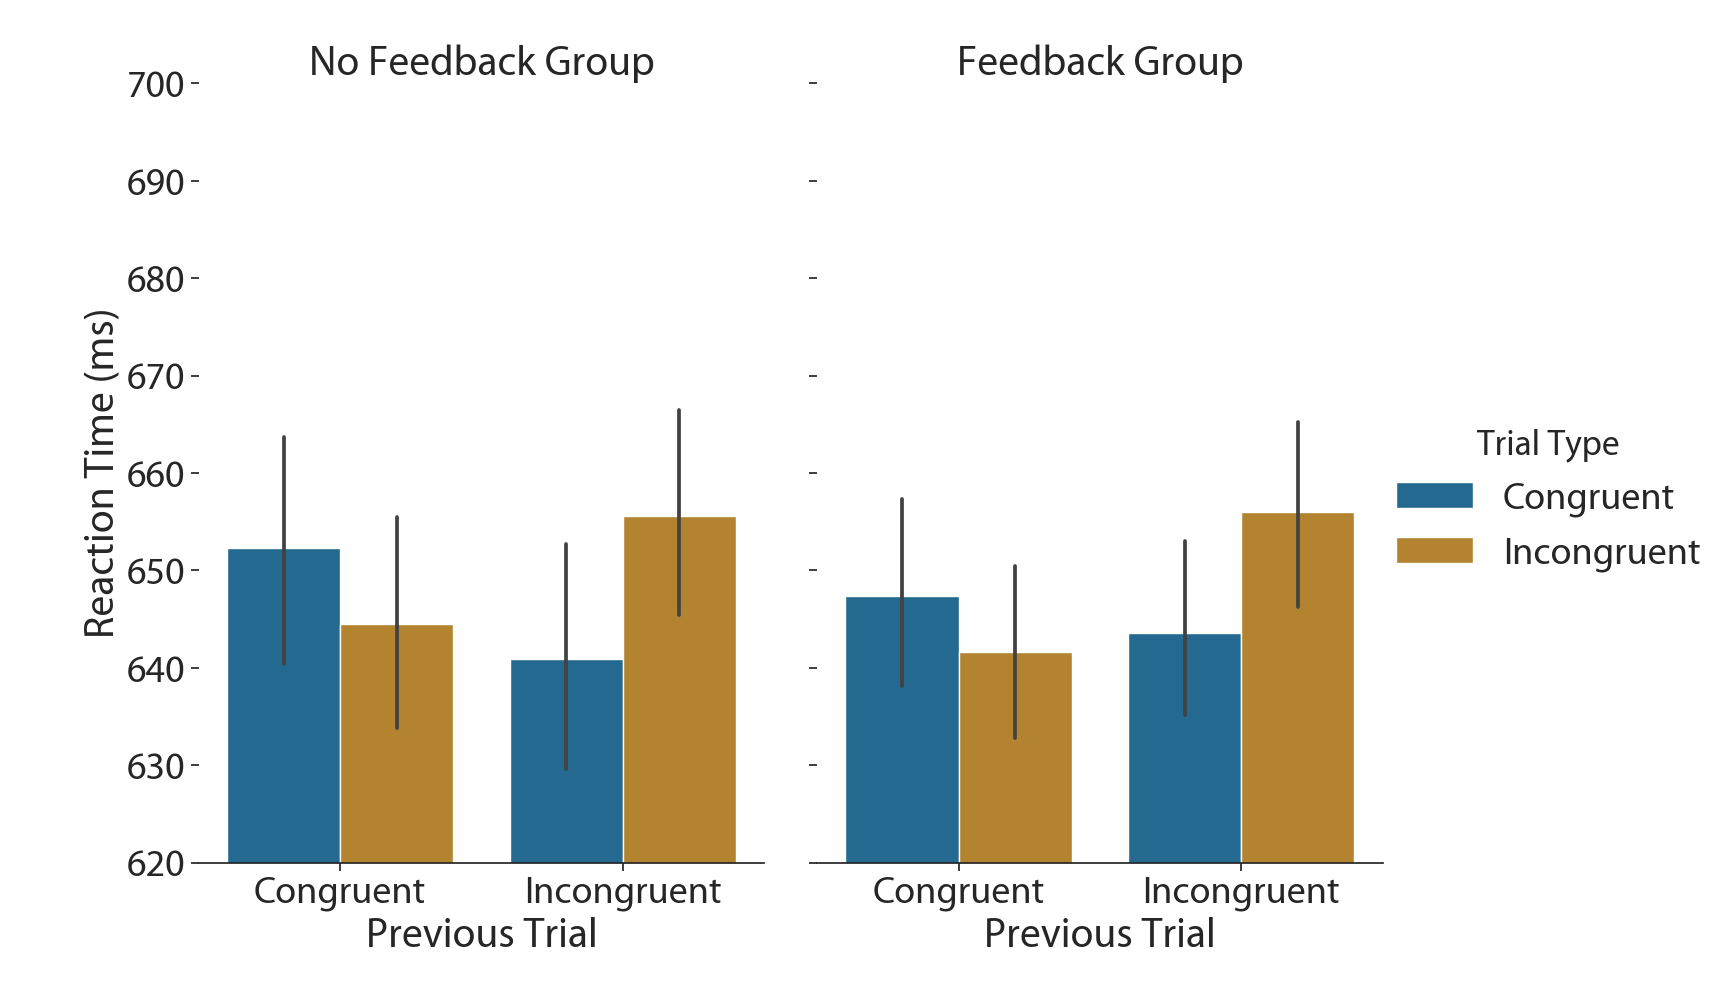

In [480]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT_T,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect on Transfer for FB Grps","Trial Type",620,700,"CSE_RT_T.png",10)

<IPython.core.display.Javascript object>


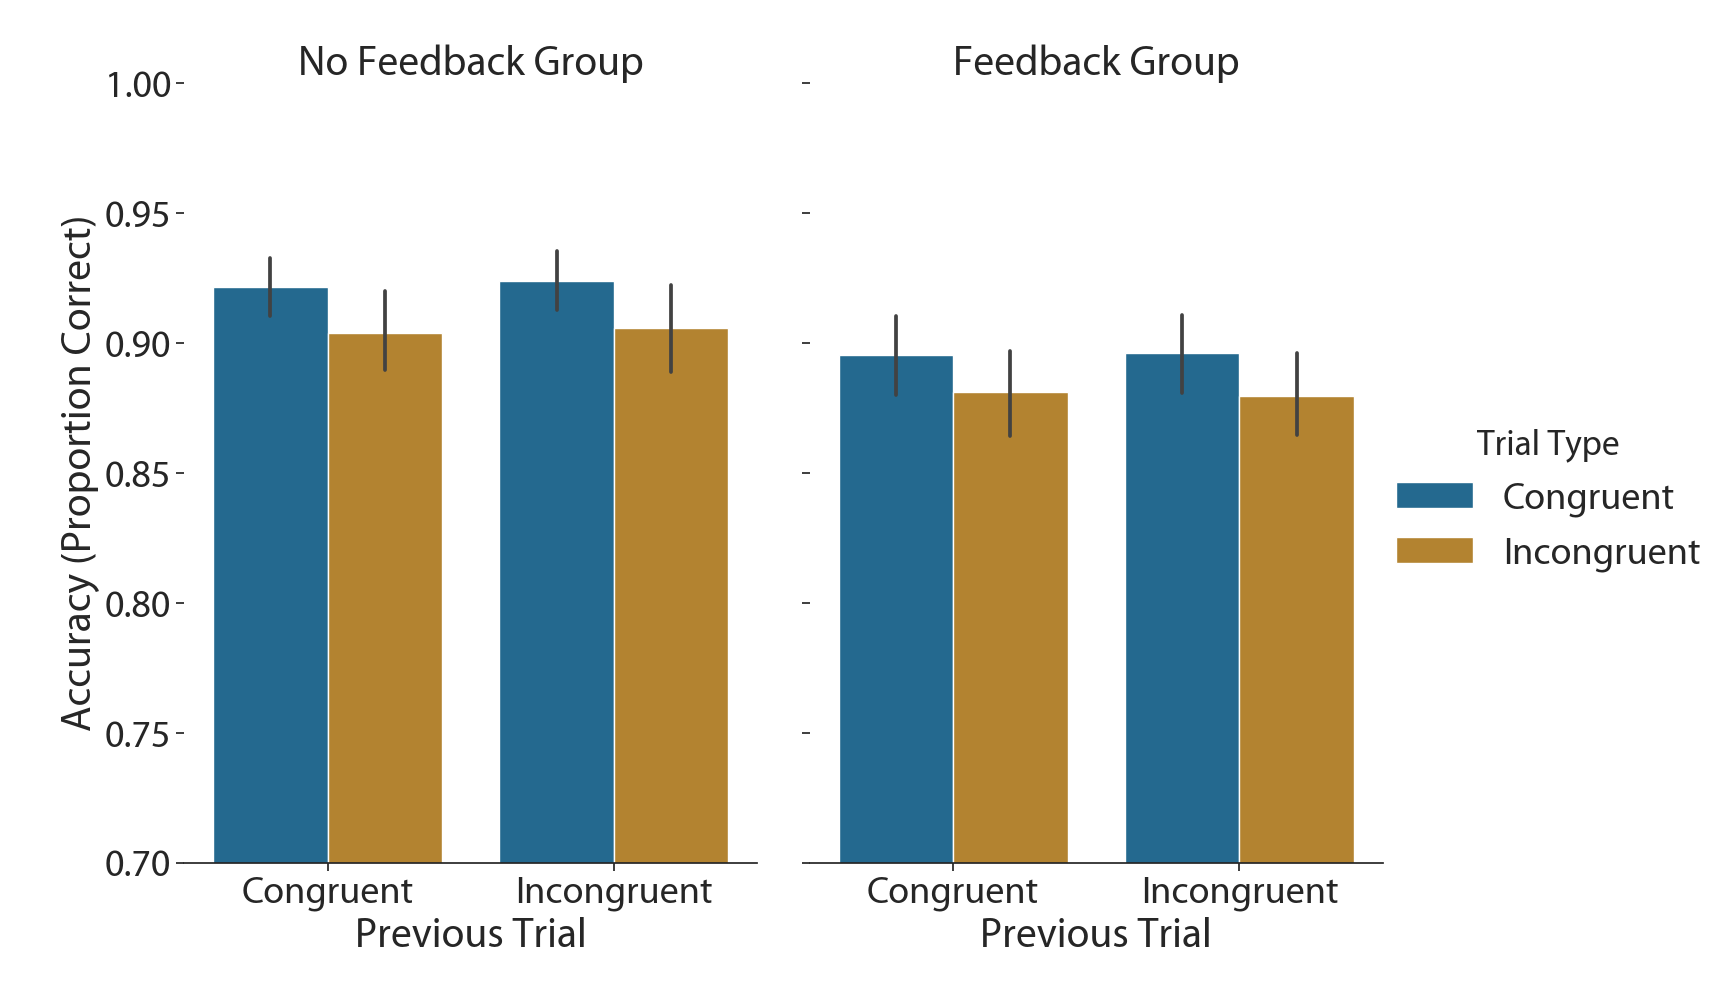

In [481]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect for FB Grps","Trial Type",0.7,1.0,"CSE_ACC.png",0.05)

<IPython.core.display.Javascript object>


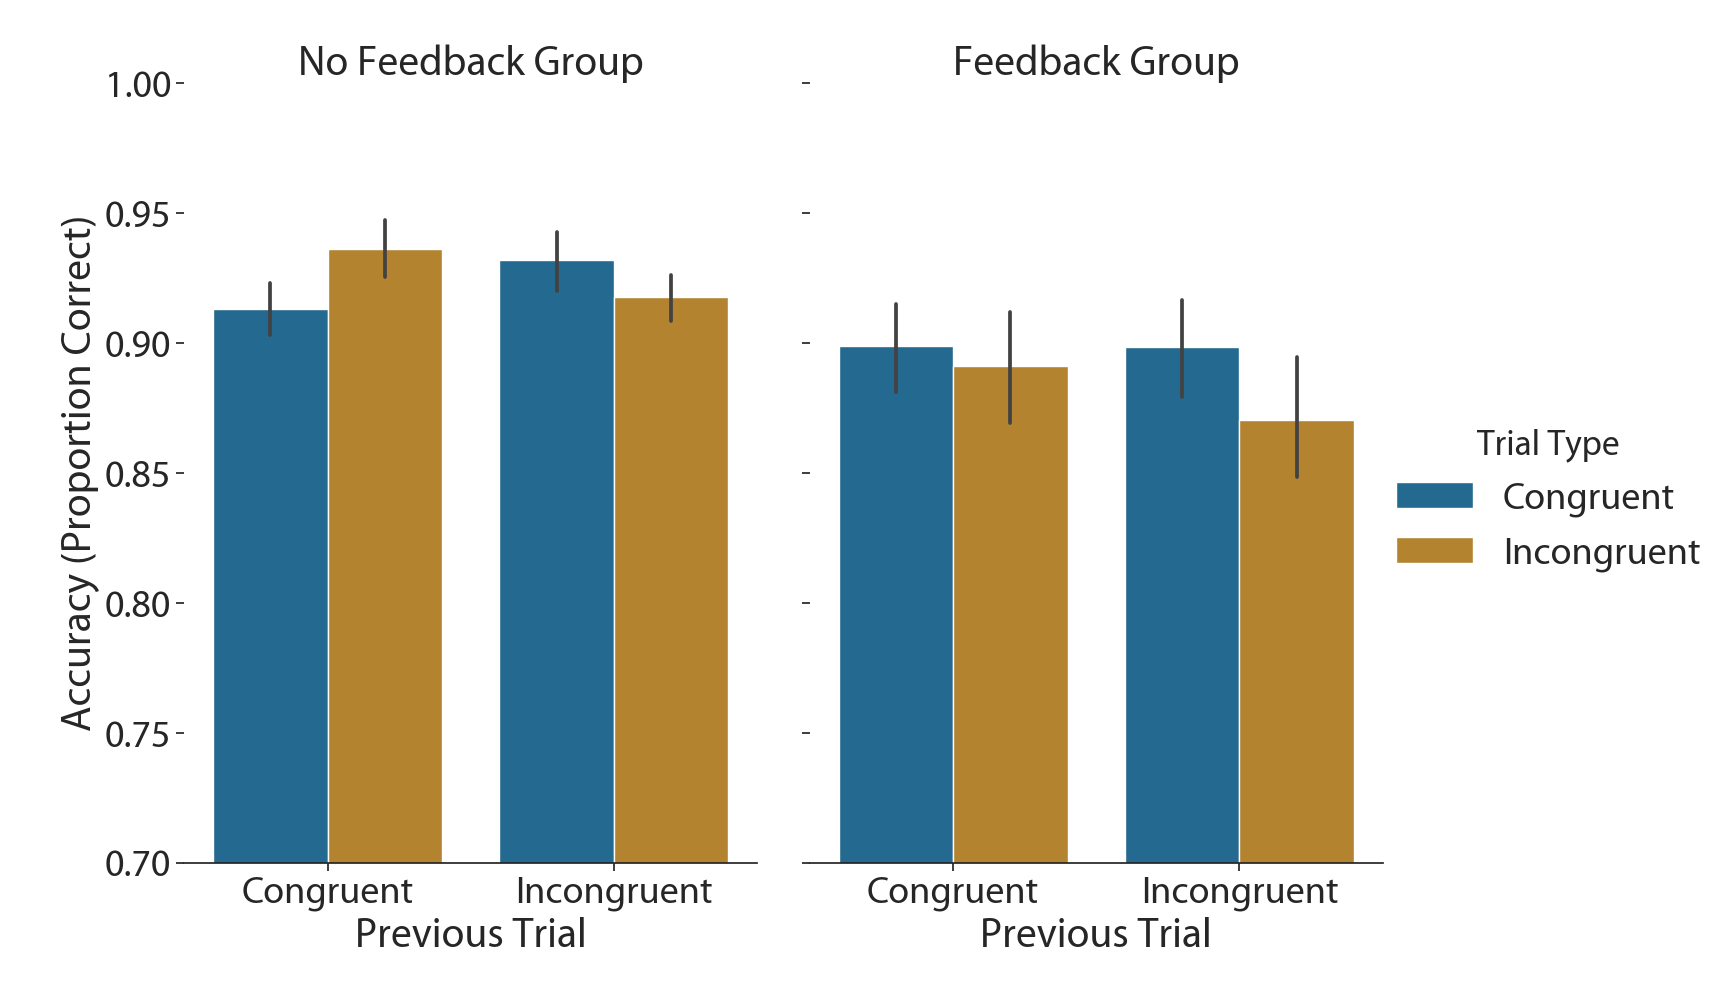

In [482]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC_T,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect on Transfer for FB Grps","Trial Type",0.7,1.0,"CSE_ACC_T.png",0.05)